In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen/') # to import ccsds
import ccsds

import struct
import collections
import pathlib

In [2]:
CE5_AOSInsertZone = Struct(
    'unknown' / Hex(Int16ub),
    'timestamp' / Int32ul, # in units of 1s, epoch 2012-08-01 UTC
)

CE5_AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'insert_zone' / CE5_AOSInsertZone,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / Bytes(235)
)

def get_packet(p):
    return p[0] if type(p) is tuple else p

def packets_asarray(packets):
    return np.array([np.frombuffer(get_packet(p)[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
                     for p in packets])

def plot_apids(apids, sc, vc):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0])
        plt.title(f"Chang'e 5 Spacecraft {sc} APID {apid} Virtual channel {vc}")

def get_timestamps(x):
    return np.datetime64('2012-08-01') + np.timedelta64(1,'s')*np.array(x)
        
def get_packet_timestamps(packets):
    return get_timestamps([p[1] for p in packets])

Here we look at some Chang'e 5 high-speed data received by Bochum on 8495 MHz from the Chang'e 5 lander+ascender combo on the lunar surface on 2020-12-02. The data is divided in 5 separate files.

The frames are CCSDS concatenated frames with a Reed-solomon interleaving depth of 4. The frame size is 892 bytes including the 32 bit ASM.

In [3]:
def load_frames(path):
    frame_size = 223*4
    frames = np.fromfile(path, dtype = 'uint8')
    frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
    return frames


frames = np.concatenate([load_frames(f) for f in sorted(pathlib.Path('Bochum_2020-12-02_8495').glob('*.u8'))])

## AOS frames

AOS frames come from spacecraft ID 99, virtual channels 1, 2 and 63 (the idle virtual channel). Other combinations are most likely to corruted frames despite the fact that the Reed-Solomon decoder was successful.

In [4]:
aos = [CE5_AOSFrame.parse(f) for f in frames]

In [5]:
collections.Counter([a.primary_header.transfer_frame_version_number for a in aos])

Counter({1: 79017, 3: 6, 2: 1})

In [6]:
collections.Counter([a.primary_header.spacecraft_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({99: 79017})

In [7]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({63: 78753, 1: 261, 40: 3})

## Virtual channel 63

Virtual channel 63 contains padding. Besides the AOS header, there is a 6 byte insert zone which contains `0xf0f0` and a timestamp (in the same format as the low rate telemetry). The remaining data starts with `0x3ffe` and then there are padding `0xaa` bytes until the end.

Note that the `0x3ffe` can be explained as a B_PDU header that indicates only idle data in the B_PDU bitstream data zone (see 4.1.4.3.3.4 in the [AOS Space Data Link Protocol](https://public.ccsds.org/Pubs/732x0b3e1.pdf)) blue book.

In [8]:
vc63 = [a for a in aos if a.primary_header.virtual_channel_id == 63
       and a.primary_header.transfer_frame_version_number == 1]
[a.primary_header for a in vc63[:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=63, virtual_channel_frame_count=6750130, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=63, virtual_channel_frame_count=6750131, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=63, virtual_channel_frame_count=6750132, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=63, virtual_channel_frame_count=6750133, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=63, virtual_channel_frame_count=6750134, replay_flag=False, vc_frame_co

In [9]:
frames_vc63 = frames[[a.primary_header.virtual_channel_id == 63
                      and a.primary_header.transfer_frame_version_number == 1
                      for a in aos]]

In [10]:
np.unique(frames_vc63[:,12])

array([63], dtype=uint8)

In [11]:
np.unique(frames_vc63[:,13])

array([254], dtype=uint8)

In [12]:
hex(63), hex(254)

('0x3f', '0xfe')

In [13]:
np.unique(frames_vc63[:,14:])

array([170], dtype=uint8)

In [14]:
hex(170)

'0xaa'

In [15]:
{hex(a.insert_zone.unknown) for a in vc63}

{'0xf0f0'}

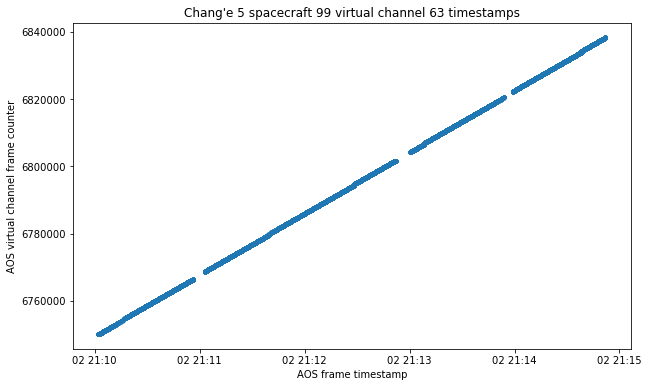

In [16]:
vc63_timestamps = get_timestamps([a.insert_zone.timestamp for a in vc63])
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc63])
sort = np.argsort(fc)

plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(vc63_timestamps[sort], fc[sort], '.')
plt.title("Chang'e 5 spacecraft 99 virtual channel 63 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

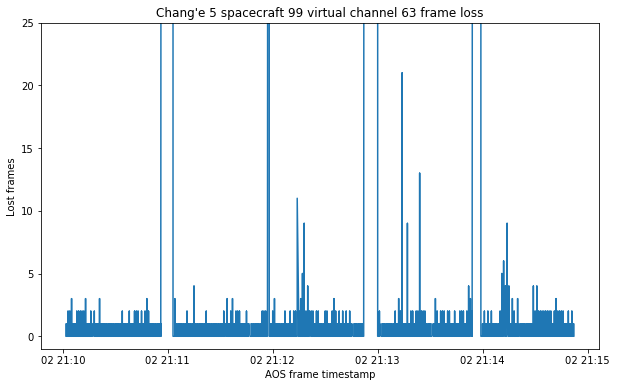

In [17]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(vc63_timestamps[sort][1:], np.diff(fc[sort])-1)
plt.ylim((-1,25))
plt.title("Chang'e 5 spacecraft 99 virtual channel 63 frame loss")
plt.xlabel('AOS frame timestamp')
plt.ylabel('Lost frames');

## Virtual channel 1

Virtual channel 1 contains something like a B_PDU header, but the bitstream data pointer uses units of bytes rather than bits. The contents of the data section are Space Packets, so it is not clear why M_PDU is not used.

The Space Packets are back-to-back, except for some that have one extra byte in between (is this a bug)? The last bytes of the frame are unused and filled with `0xaa` padding. Space Packets are not fragmented between frames.

This seems to be real-time telemetry, very similar to the one sent in virtual channel 1 in the low datarate signals.

In [18]:
vc1 = [a for a in aos if a.primary_header.virtual_channel_id == 1]
[a.primary_header for a in vc1[:5]]

[Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=1, virtual_channel_frame_count=260988, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=1, virtual_channel_frame_count=260989, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=1, virtual_channel_frame_count=260990, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=1, virtual_channel_frame_count=260991, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=1, virtual_channel_frame_count=260992, replay_flag=False, vc_frame_count_usage_

The timestamps of these packets seem to span too much time for this short recording. I think this has something to do with the underlying replay data.

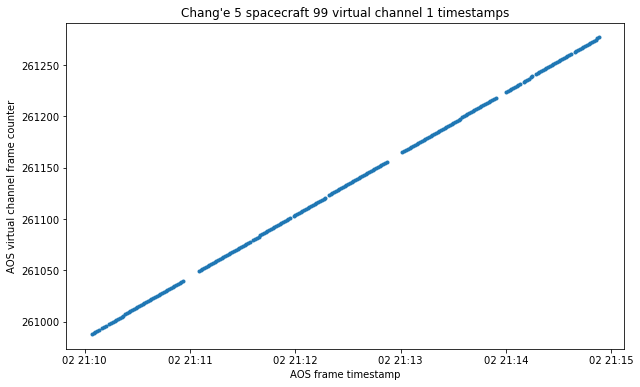

In [19]:
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc1])
vc1_timestamps = get_timestamps([a.insert_zone.timestamp for a in vc1])

plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(vc1_timestamps, fc, '.')
plt.title("Chang'e 5 spacecraft 99 virtual channel 1 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

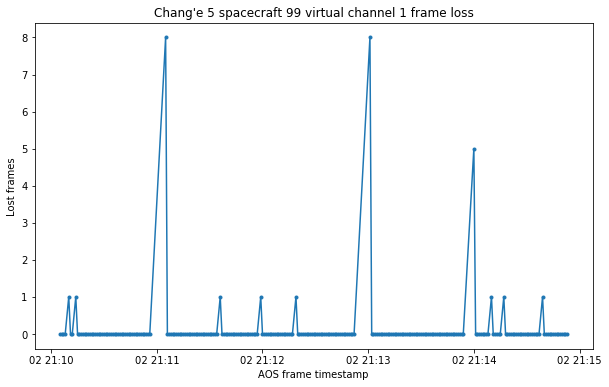

In [20]:
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc1])
vc1_timestamps = get_timestamps([a.insert_zone.timestamp for a in vc1])

plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(vc1_timestamps[1:], np.diff(fc)-1, '.-')
plt.title("Chang'e 5 spacecraft 99 virtual channel 1 frame loss")
plt.xlabel('AOS frame timestamp')
plt.ylabel('Lost frames');

In [21]:
vc1_timestamps[:10]

array(['2020-12-02T21:10:04', '2020-12-02T21:10:05',
       '2020-12-02T21:10:06', '2020-12-02T21:10:07',
       '2020-12-02T21:10:08', '2020-12-02T21:10:10',
       '2020-12-02T21:10:11', '2020-12-02T21:10:12',
       '2020-12-02T21:10:14', '2020-12-02T21:10:15'],
      dtype='datetime64[s]')

In [22]:
frames_vc1 = frames[[a.primary_header.virtual_channel_id == 1
                      and a.primary_header.transfer_frame_version_number == 1
                      for a in aos]]

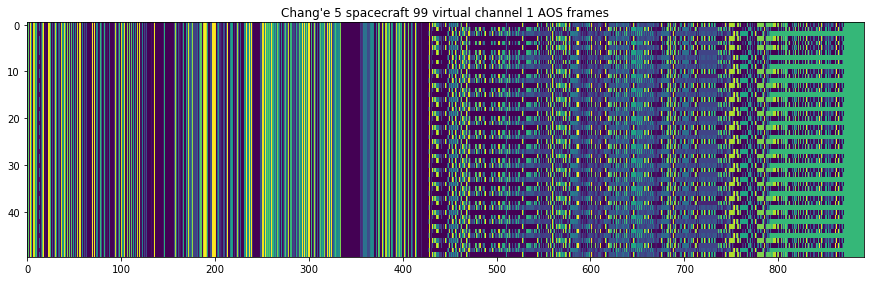

In [23]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames_vc1[:50, :], aspect = 5)
plt.title("Chang'e 5 spacecraft 99 virtual channel 1 AOS frames");

In [24]:
frame_len = frames_vc1[:, 12:14].ravel().view('int16').byteswap()

In [25]:
frame_lens = np.unique(frame_len)
frame_lens

array([778, 856, 858], dtype=int16)

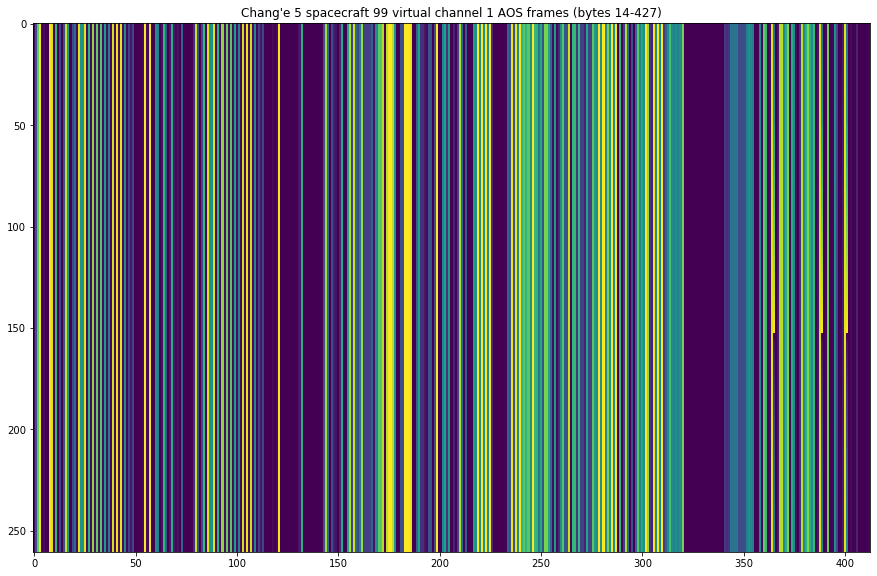

In [26]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames_vc1[:, 14:427], aspect = 1)
plt.title("Chang'e 5 spacecraft 99 virtual channel 1 AOS frames (bytes 14-427)");

In [27]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in frames_vc1[:5,14:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=831, sequence_flags=3, packet_sequence_count_or_name=508, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=831, sequence_flags=3, packet_sequence_count_or_name=508, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=831, sequence_flags=3, packet_sequence_count_or_name=508, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=831, sequence_flags=3, packet_sequence_count_or_name=508, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=831, sequence_flags=3, packet_sequence_count_or_name=508, data_length=7)]

In [28]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in frames_vc1[:5,14+6+8:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=573, sequence_flags=3, packet_sequence_count_or_name=11144, data_length=57),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=573, sequence_flags=3, packet_sequence_count_or_name=11144, data_length=57),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=573, sequence_flags=3, packet_sequence_count_or_name=11144, data_length=57),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=573, sequence_flags=3, packet_sequence_count_or_name=11144, data_length=57),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=573, sequence_flags=3, packet_sequence_count_or_name=11144, data_length=57)]

In [29]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in frames_vc1[:5,14+6+8+6+58:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=545, sequence_flags=3, packet_sequence_count_or_name=11069, data_length=57),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=545, sequence_flags=3, packet_sequence_count_or_name=11069, data_length=57),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=545, sequence_flags=3, packet_sequence_count_or_name=11069, data_length=57),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=545, sequence_flags=3, packet_sequence_count_or_name=11069, data_length=57),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=545, sequence_flags=3, packet_sequence_count_or_name=11069, data_length=57)]

In [30]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in frames_vc1[:5, 376:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=520, sequence_flags=3, packet_sequence_count_or_name=13146, data_length=16),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=520, sequence_flags=3, packet_sequence_count_or_name=13147, data_length=16),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=520, sequence_flags=3, packet_sequence_count_or_name=13148, data_length=16),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=520, sequence_flags=3, packet_sequence_count_or_name=13149, data_length=16),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=520, sequence_flags=3, packet_sequence_count_or_name=13150, data_length=16)]

In [31]:
# there is a bug here! the data_length of the previous packet should be 17 rather than 16
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in frames_vc1[:5, 376+6+18:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=526, sequence_flags=3, packet_sequence_count_or_name=13146, data_length=5),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=526, sequence_flags=3, packet_sequence_count_or_name=13147, data_length=5),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=526, sequence_flags=3, packet_sequence_count_or_name=13148, data_length=5),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=526, sequence_flags=3, packet_sequence_count_or_name=13149, data_length=5),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=526, sequence_flags=3, packet_sequence_count_or_name=13150, data_length=5)]

In [32]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in frames_vc1[:5, 376+6+18+6+6:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=531, sequence_flags=3, packet_sequence_count_or_name=13146, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=531, sequence_flags=3, packet_sequence_count_or_name=13147, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=531, sequence_flags=3, packet_sequence_count_or_name=13148, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=531, sequence_flags=3, packet_sequence_count_or_name=13149, data_length=7),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=531, sequence_flags=3, packet_sequence_count_or_name=13150, data_length=7)]

In [33]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in frames_vc1[:5, 376+6+18+6+6+6+8:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=514, sequence_flags=3, packet_sequence_count_or_name=13146, data_length=11),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=779, sequence_flags=3, packet_sequence_count_or_name=13147, data_length=20),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=548, sequence_flags=3, packet_sequence_count_or_name=5883, data_length=25),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=514, sequence_flags=3, packet_sequence_count_or_name=13149, data_length=11),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=779, sequence_flags=3, packet_sequence_count_or_name=13150, data_length=20)]

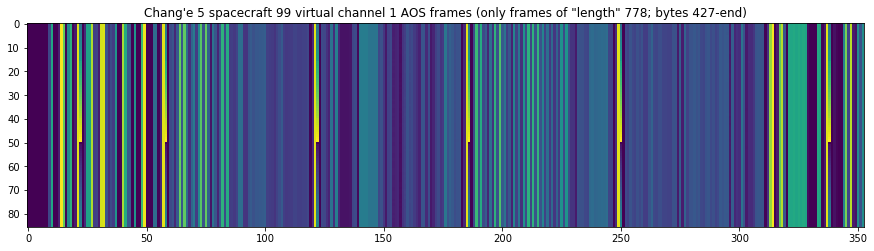

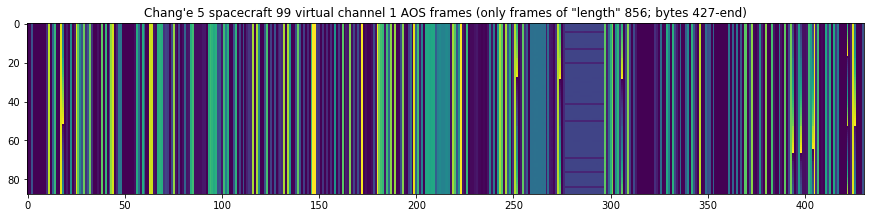

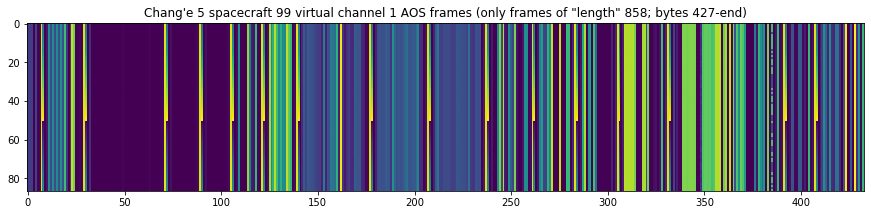

In [34]:
for j in range(frame_lens.size):
    sel_frames = frames_vc1[frame_len == frame_lens[j], 12:frame_lens[j]+14]
    plt.figure(figsize = (15,15), facecolor = 'w')
    plt.imshow(sel_frames[:, 427:], aspect = 1)
    plt.title(f"Chang'e 5 spacecraft 99 virtual channel 1 AOS frames (only frames of \"length\" {frame_lens[j]}; bytes 427-end)");

In [35]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in sel_frames[:5,427+5:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=515, sequence_flags=3, packet_sequence_count_or_name=13146, data_length=15),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=515, sequence_flags=3, packet_sequence_count_or_name=13149, data_length=15),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=515, sequence_flags=3, packet_sequence_count_or_name=13152, data_length=15),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=515, sequence_flags=3, packet_sequence_count_or_name=13158, data_length=15),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=515, sequence_flags=3, packet_sequence_count_or_name=13161, data_length=15)]

In [36]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in sel_frames[:5,427+5+6+16+6+36:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=516, sequence_flags=3, packet_sequence_count_or_name=13146, data_length=11),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=516, sequence_flags=3, packet_sequence_count_or_name=13149, data_length=11),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=516, sequence_flags=3, packet_sequence_count_or_name=13152, data_length=11),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=516, sequence_flags=3, packet_sequence_count_or_name=13158, data_length=11),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=516, sequence_flags=3, packet_sequence_count_or_name=13161, data_length=11)]

In [37]:
space_packets = []
for frame, length in zip(frames_vc1, frame_len):
    pointer = 14
    recover = False
    while True:
        if pointer + ccsds.SpacePacketPrimaryHeader.sizeof() > length + 14:
            # no more room in this frame
            break
        p = ccsds.SpacePacketPrimaryHeader.parse(frame[pointer:])
        # sanity check
        if p.ccsds_version != 0 or p.packet_type != 0 \
            or p.secondary_header_flag != False or p.sequence_flags != 3:
            if recover == True:
                print(f'Broken at pointer {pointer}')
                break
            else:
                # try to recover from the bug in the packet starting at 376
                print(f'Bug at pointer {pointer}; trying to recover...')
                recover = True
                pointer += 1
                continue
        else:
            recover = False
        end = pointer + ccsds.SpacePacketPrimaryHeader.sizeof() + p.data_length + 1
        space_packets.append(frame[pointer:end])
        pointer = end

Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 3

Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 4

Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 5

Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 3

Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 3

Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 453; trying to recover...
Bug at pointer 479; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 399; trying to recover...
Bug at pointer 557; trying to recover...
Bug at pointer 575; trying to recover...
Bug at pointer 827; trying to recover...
Bug at pointer 843; trying to recover...
Bug at pointer 303; trying to recover...
Bug at pointer 375; trying to recover...
Bug at pointer 3

Bug at pointer 479; trying to recover...


In [38]:
space_packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(a) for a in space_packets]

In [39]:
apids = collections.Counter([h.APID for h in space_packet_headers])
apids

Counter({831: 261,
         573: 261,
         545: 261,
         574: 261,
         560: 261,
         561: 261,
         520: 261,
         526: 261,
         531: 261,
         514: 87,
         515: 87,
         769: 87,
         516: 87,
         517: 87,
         518: 87,
         770: 87,
         521: 87,
         772: 87,
         524: 87,
         529: 87,
         776: 87,
         537: 87,
         538: 87,
         794: 87,
         777: 87,
         778: 87,
         779: 88,
         512: 88,
         568: 88,
         569: 88,
         570: 88,
         571: 88,
         803: 88,
         804: 88,
         564: 88,
         565: 88,
         566: 88,
         793: 88,
         548: 86,
         786: 86,
         541: 86,
         542: 86,
         797: 86,
         798: 86,
         547: 86,
         530: 86})

In [40]:
by_apid = {apid : [p for h,p in zip(space_packet_headers, space_packets)
                        if h.APID == apid] for apid in apids}

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


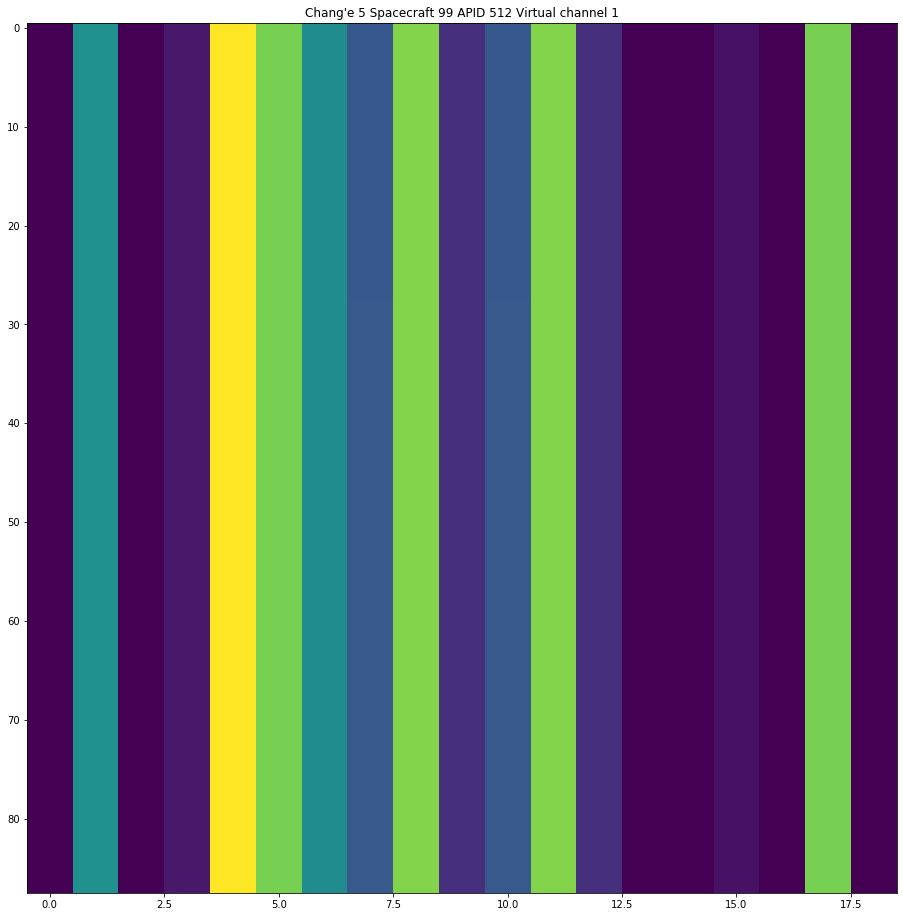

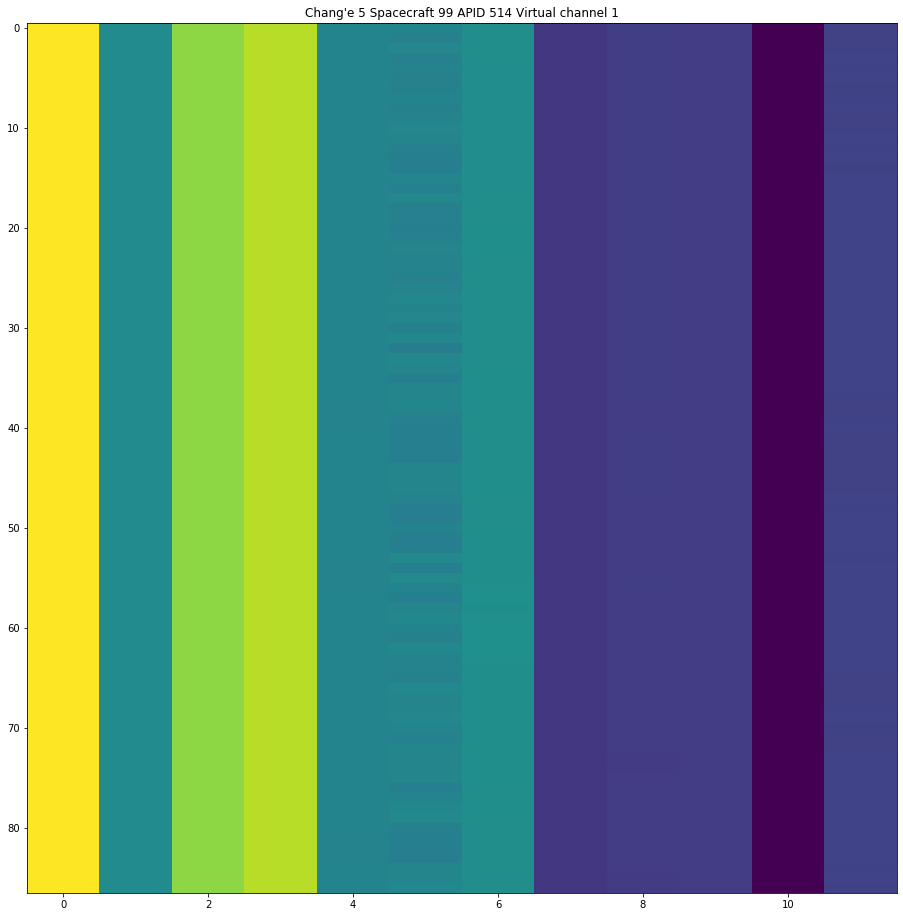

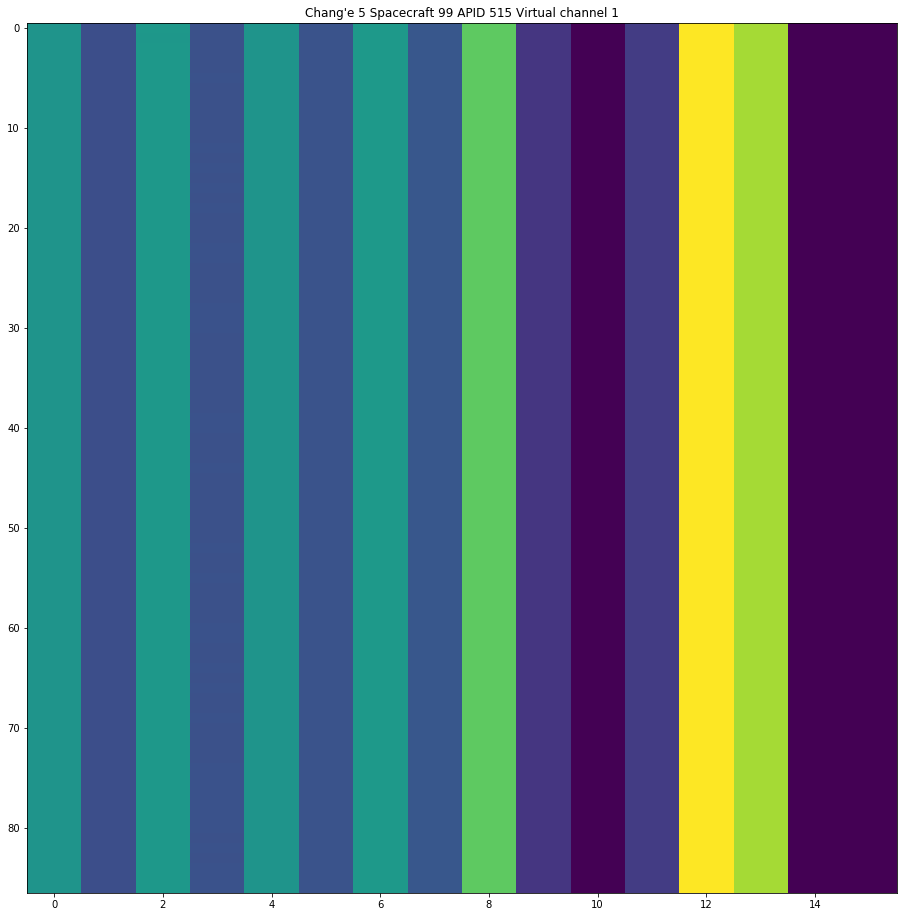

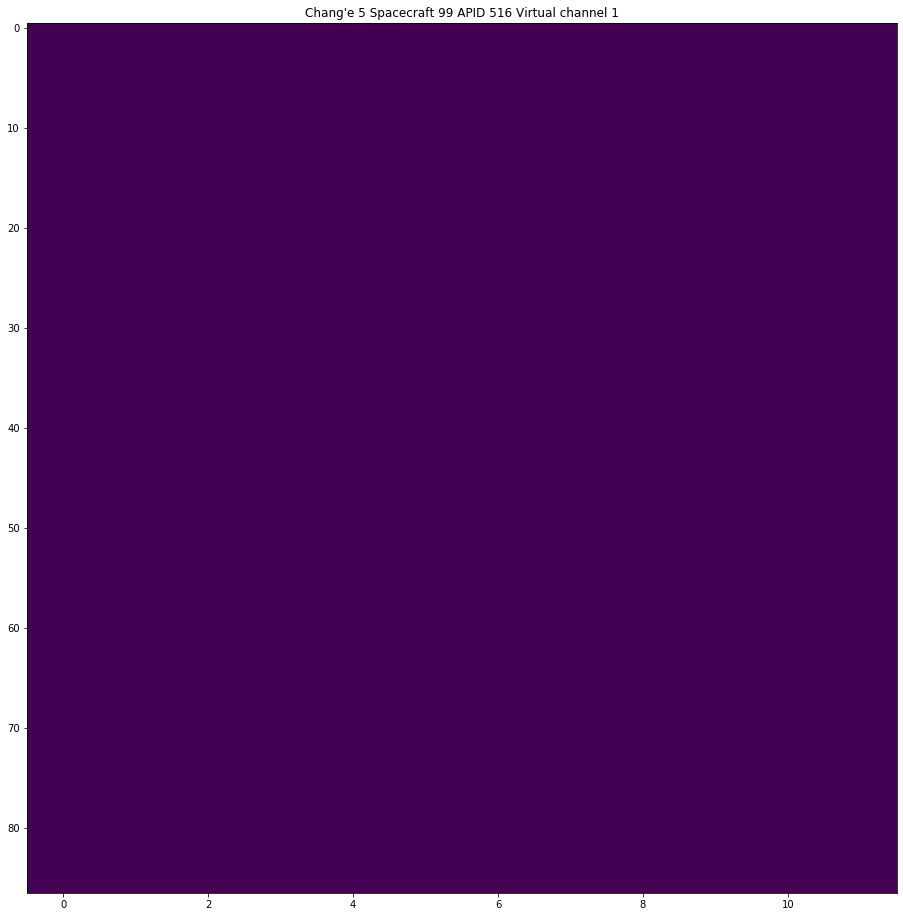

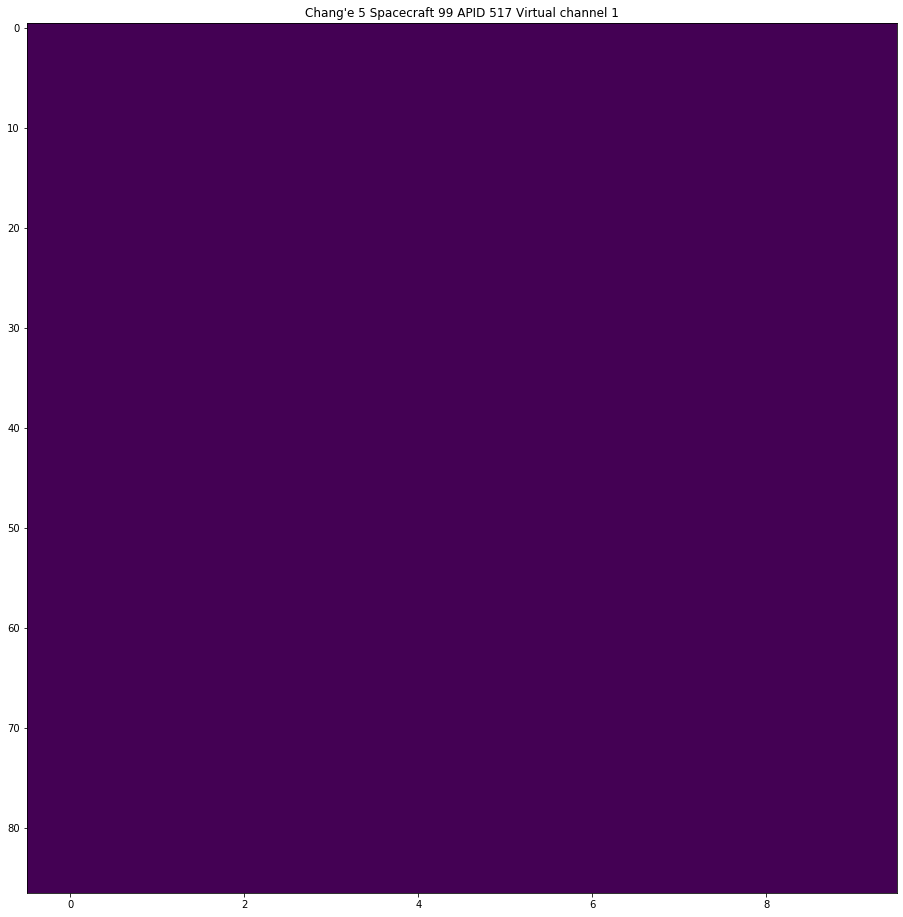

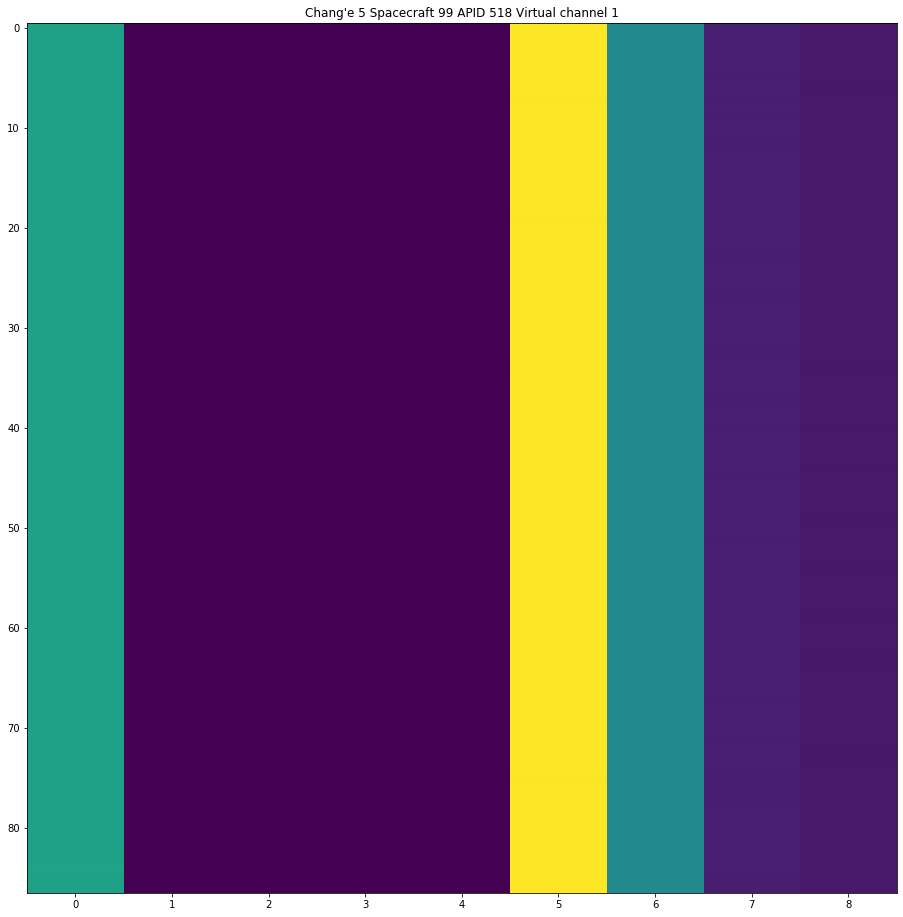

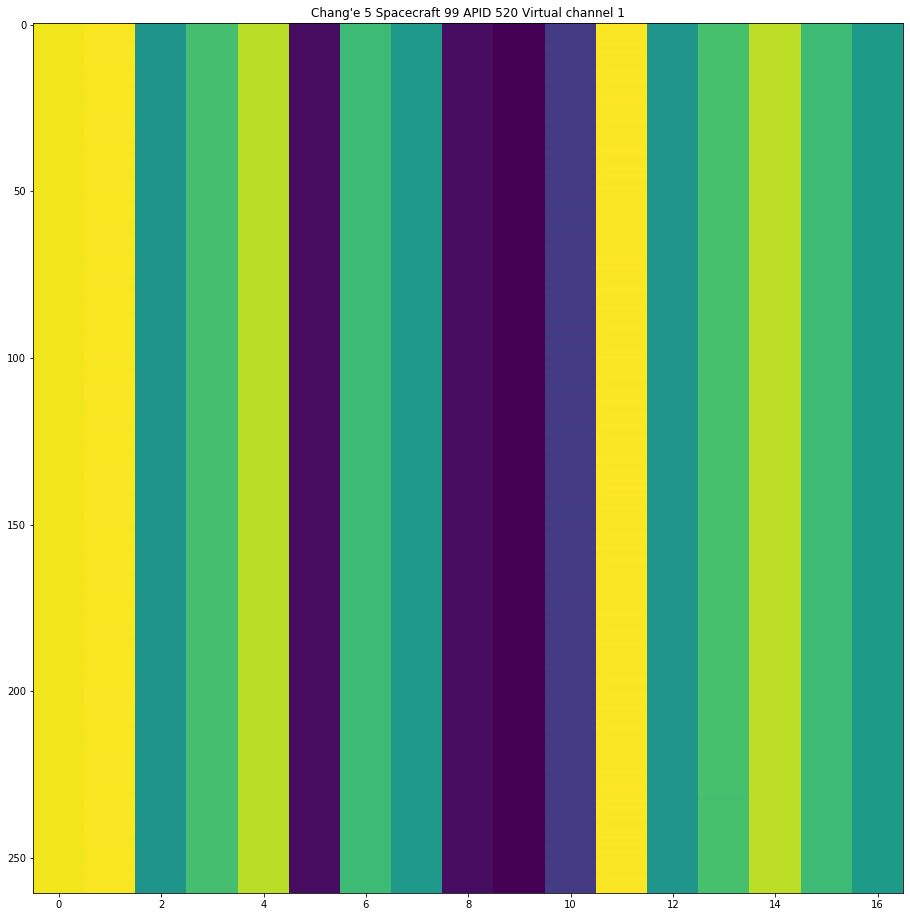

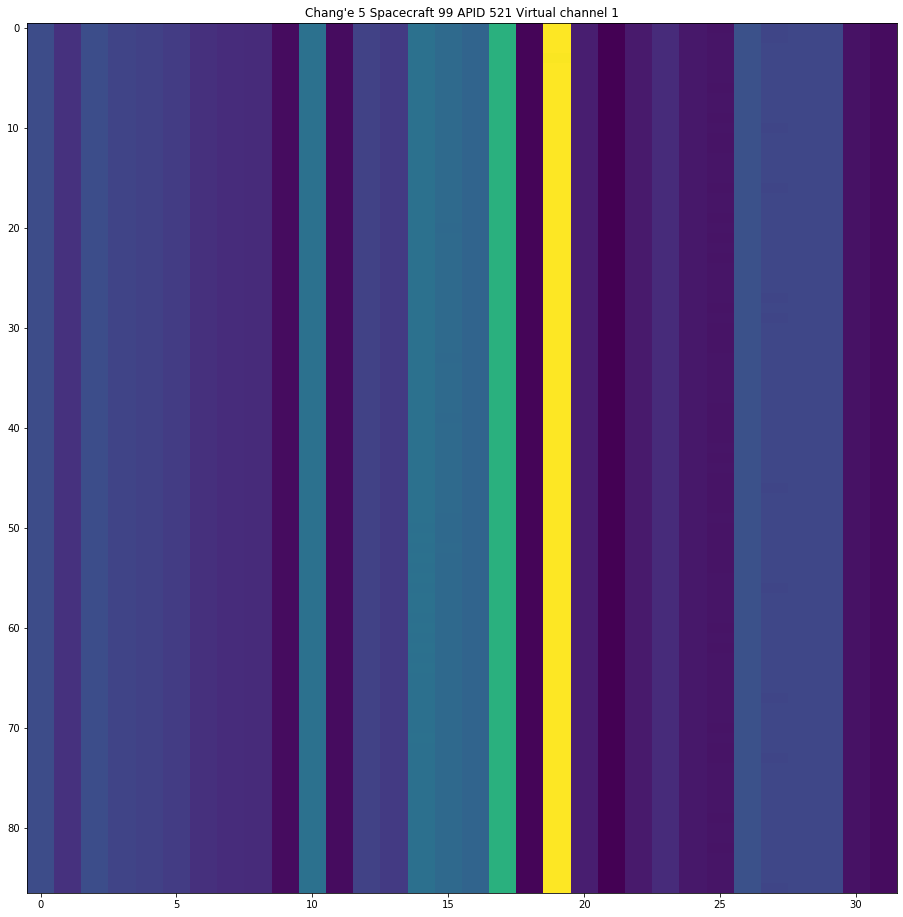

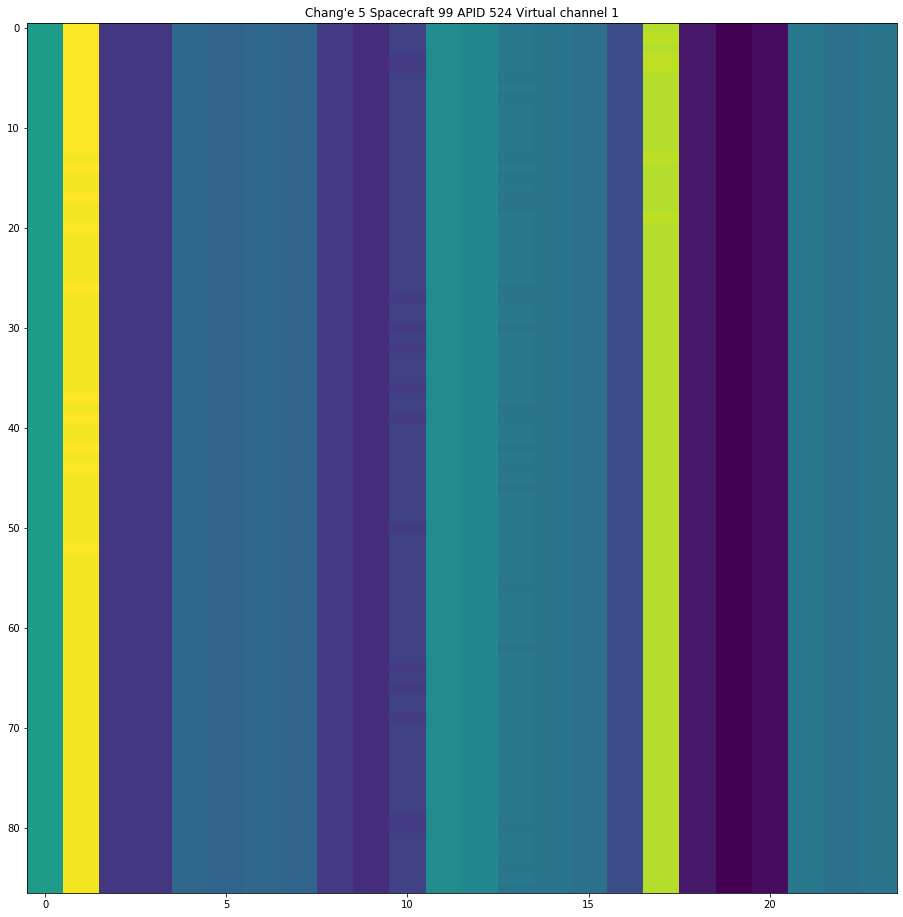

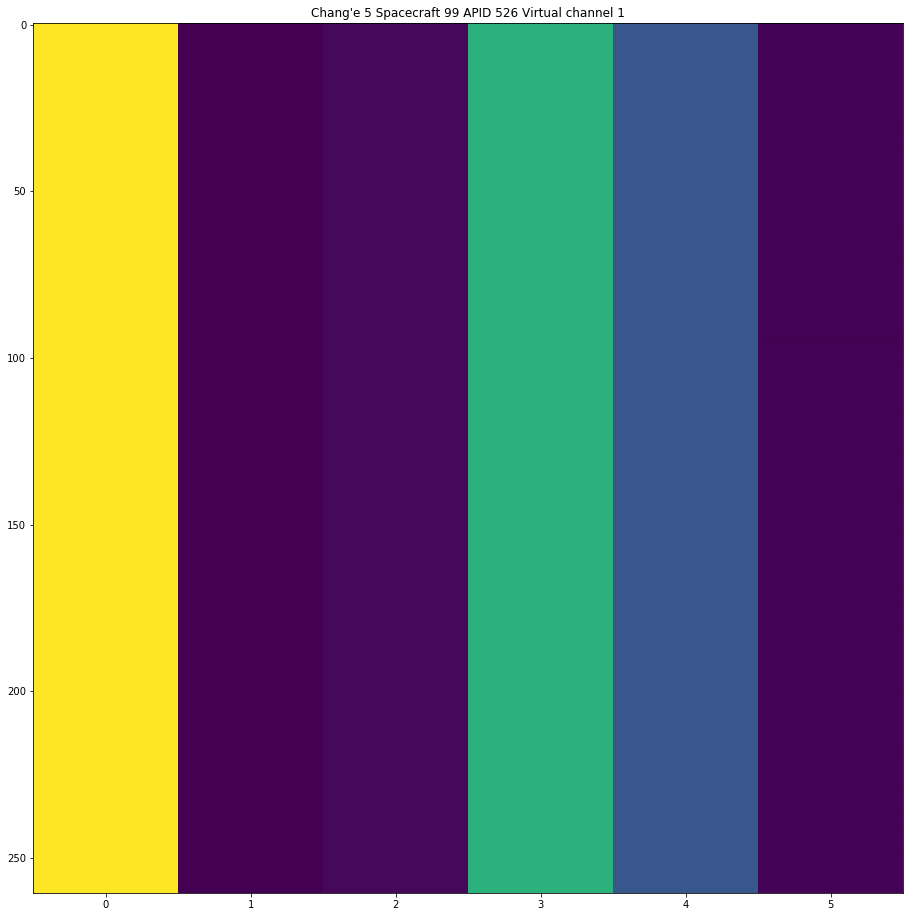

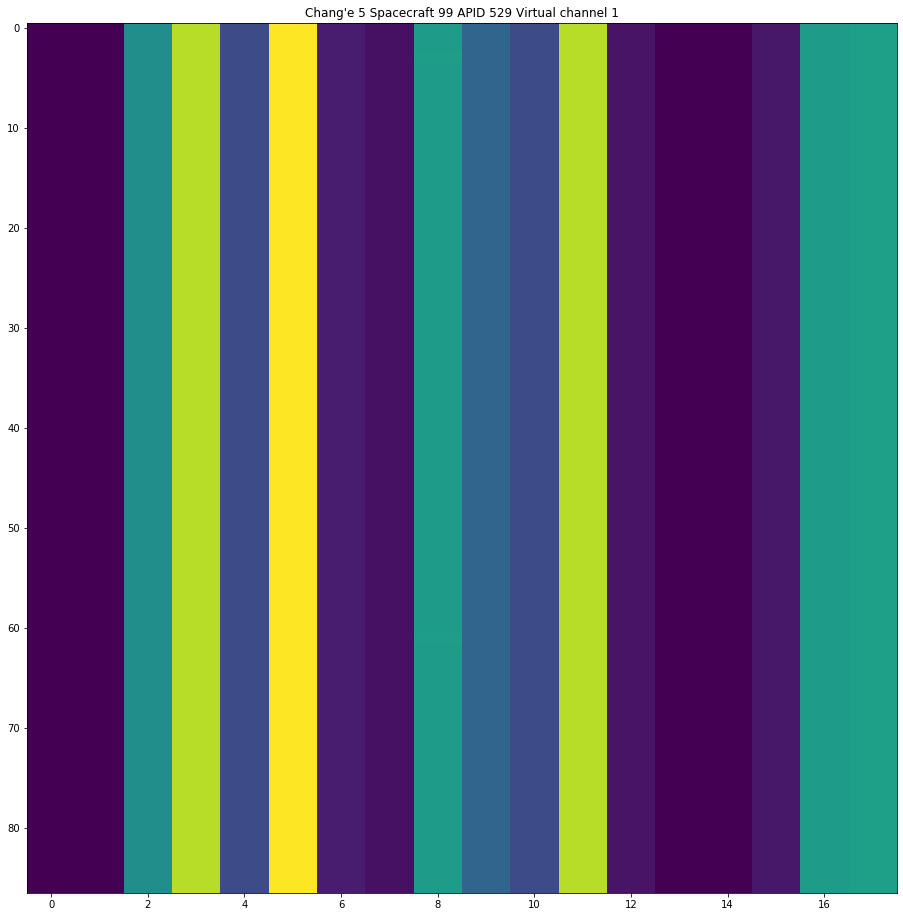

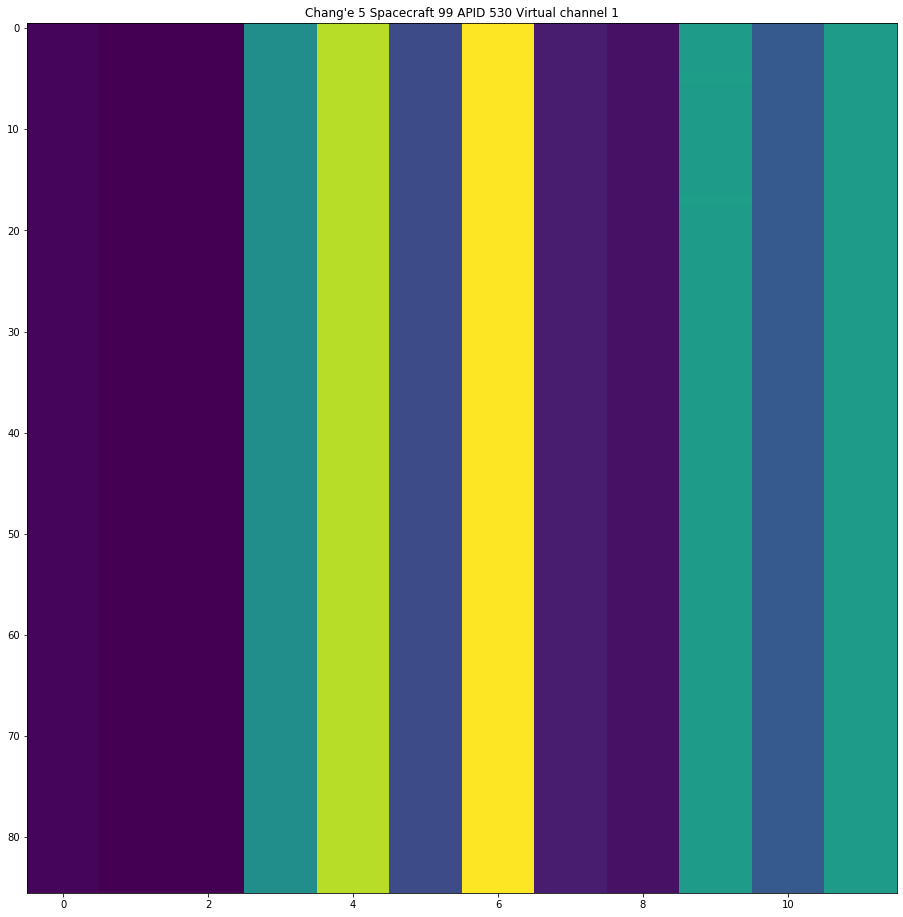

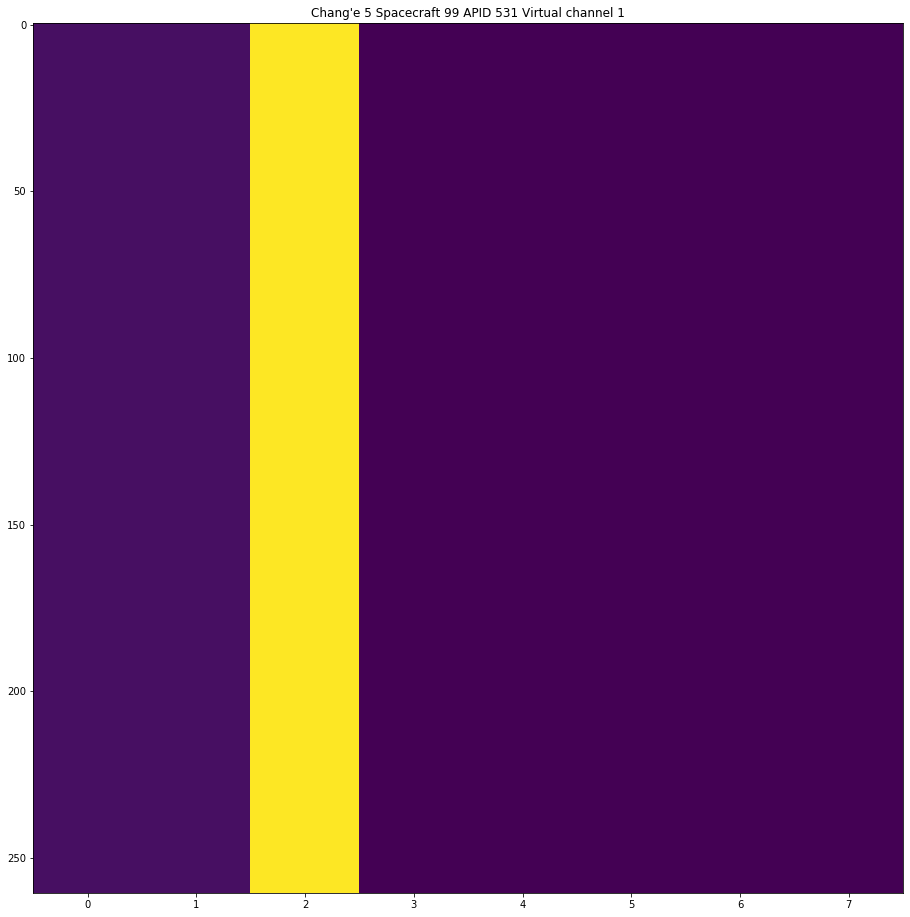

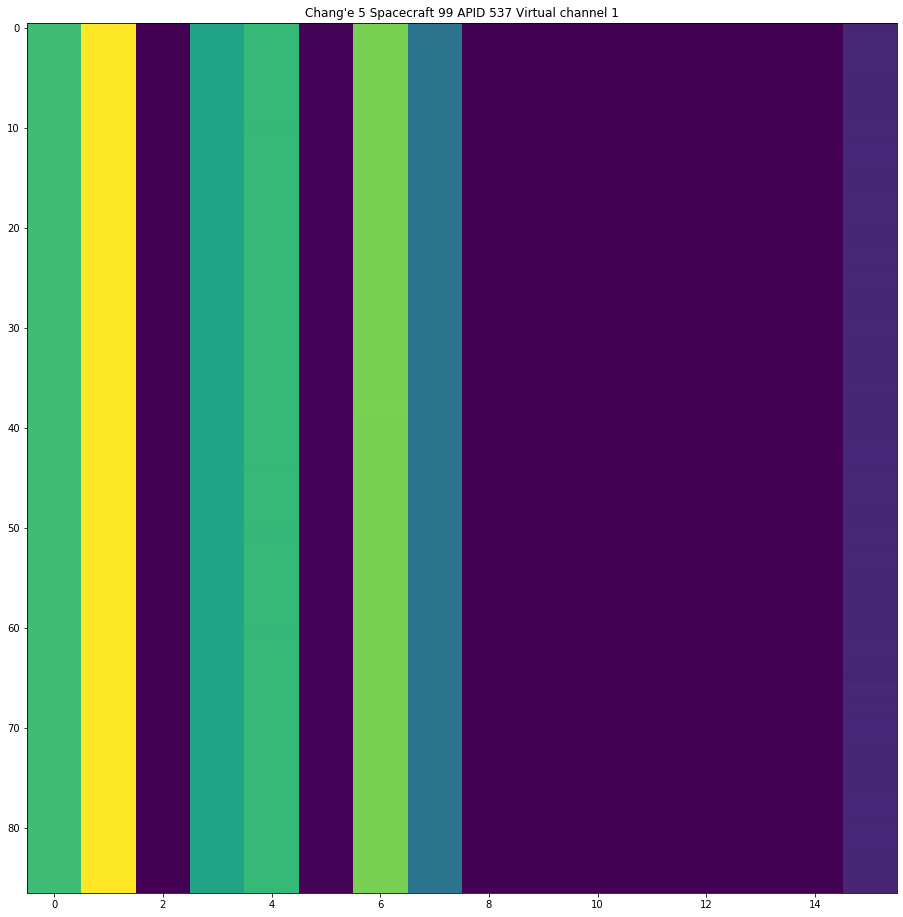

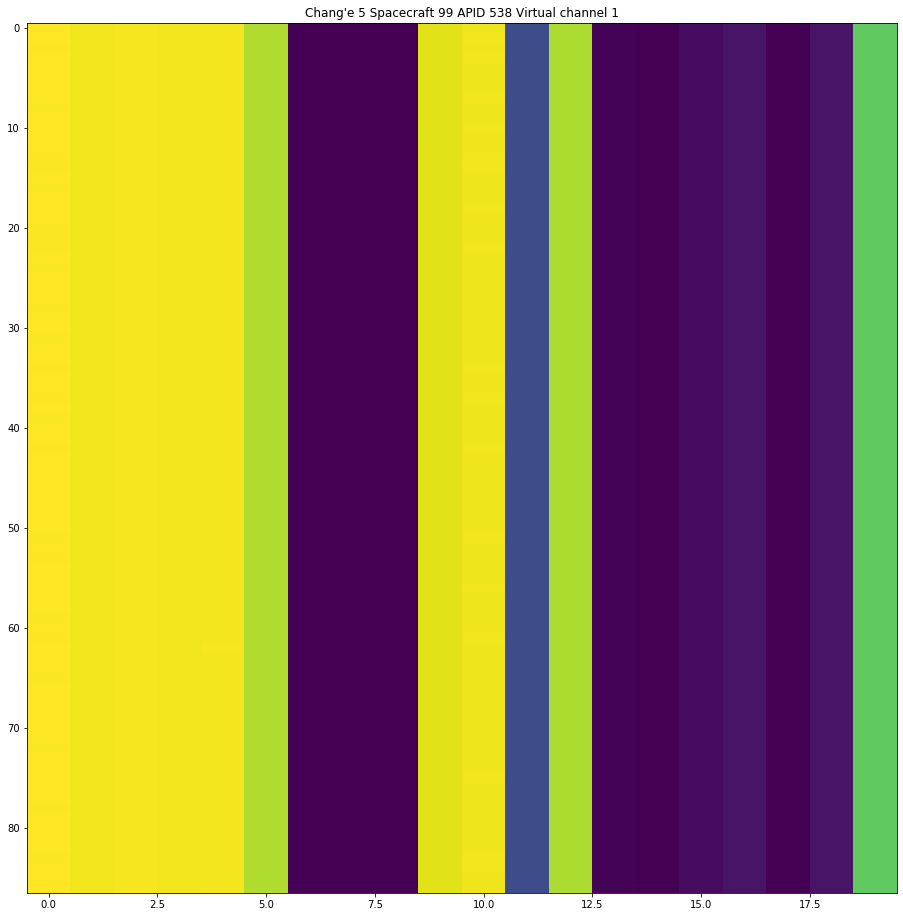

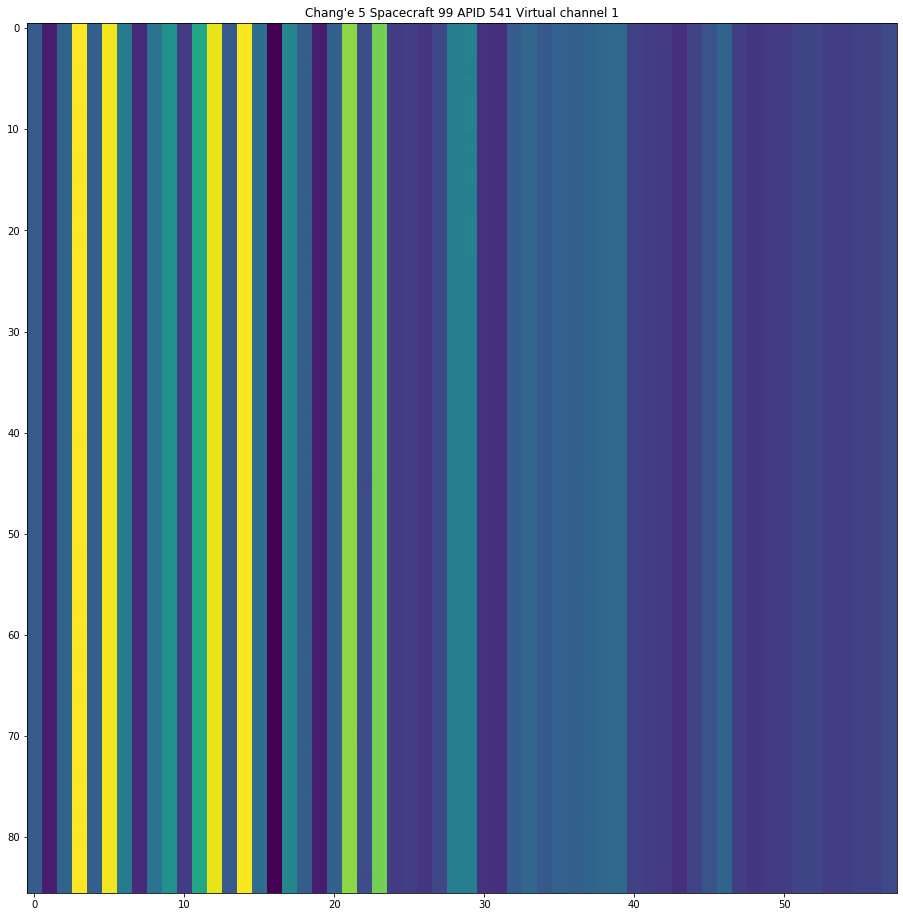

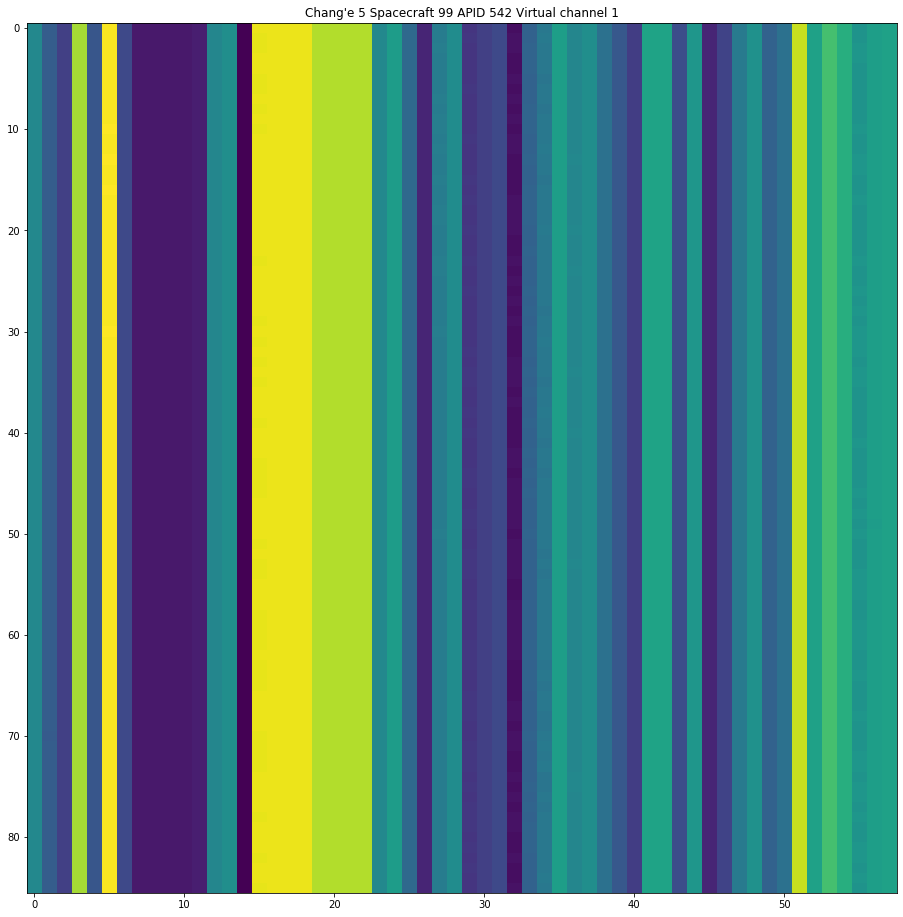

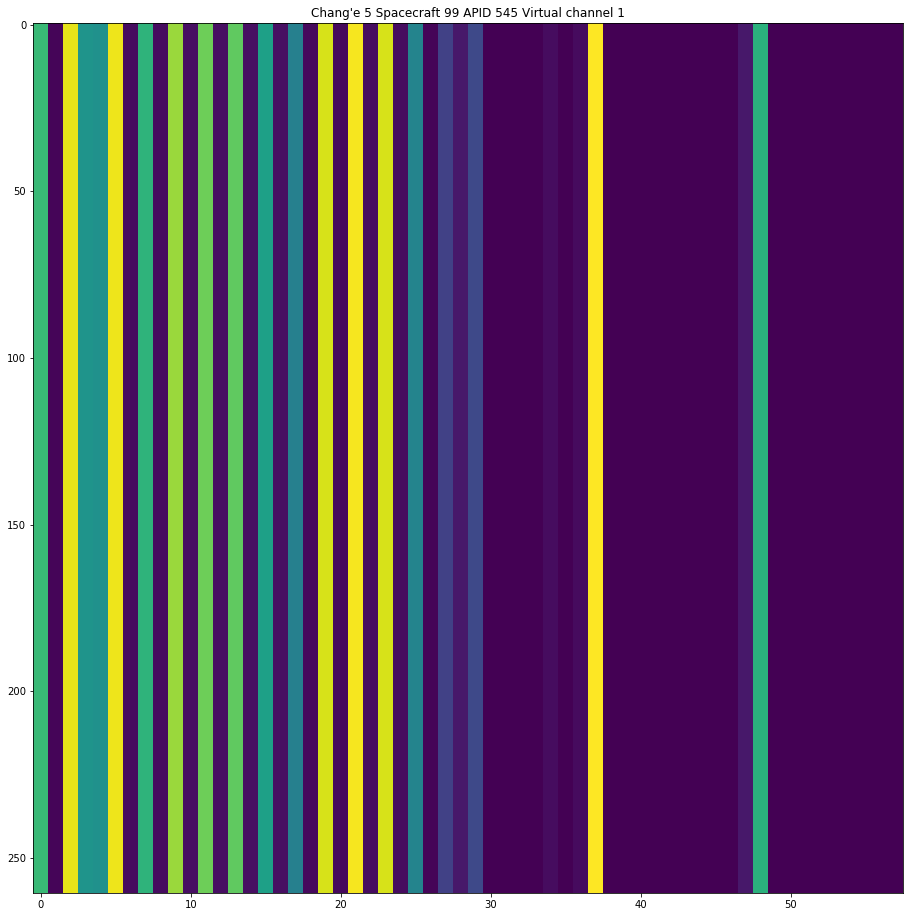

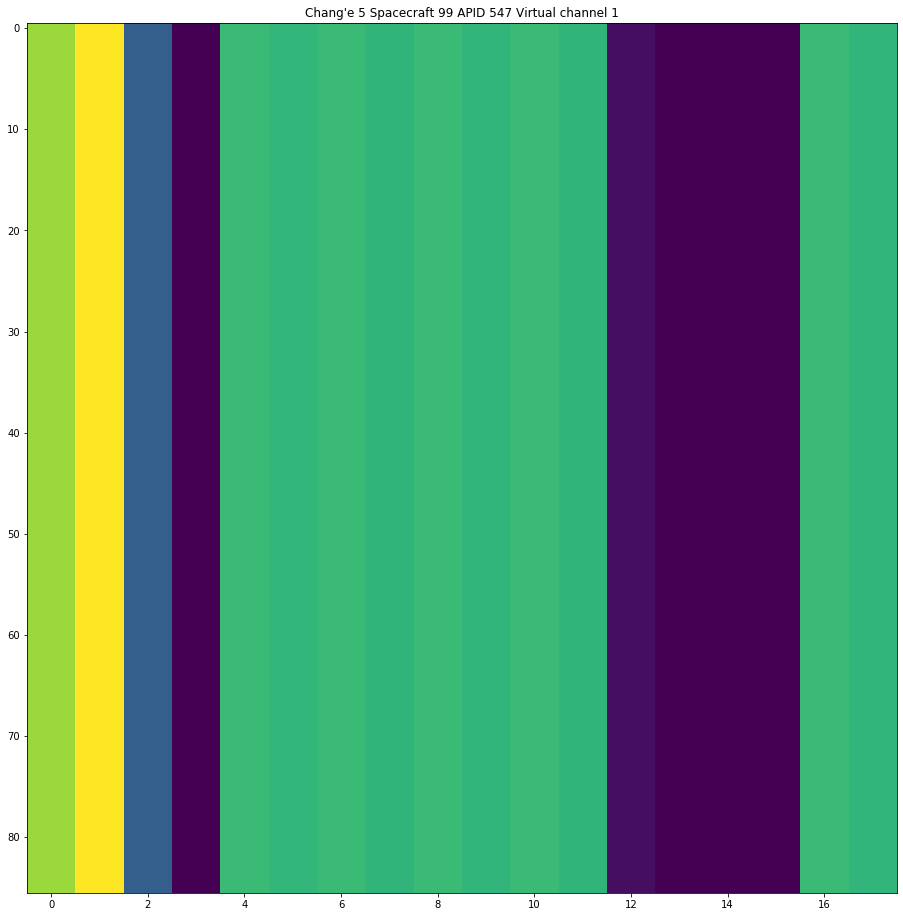

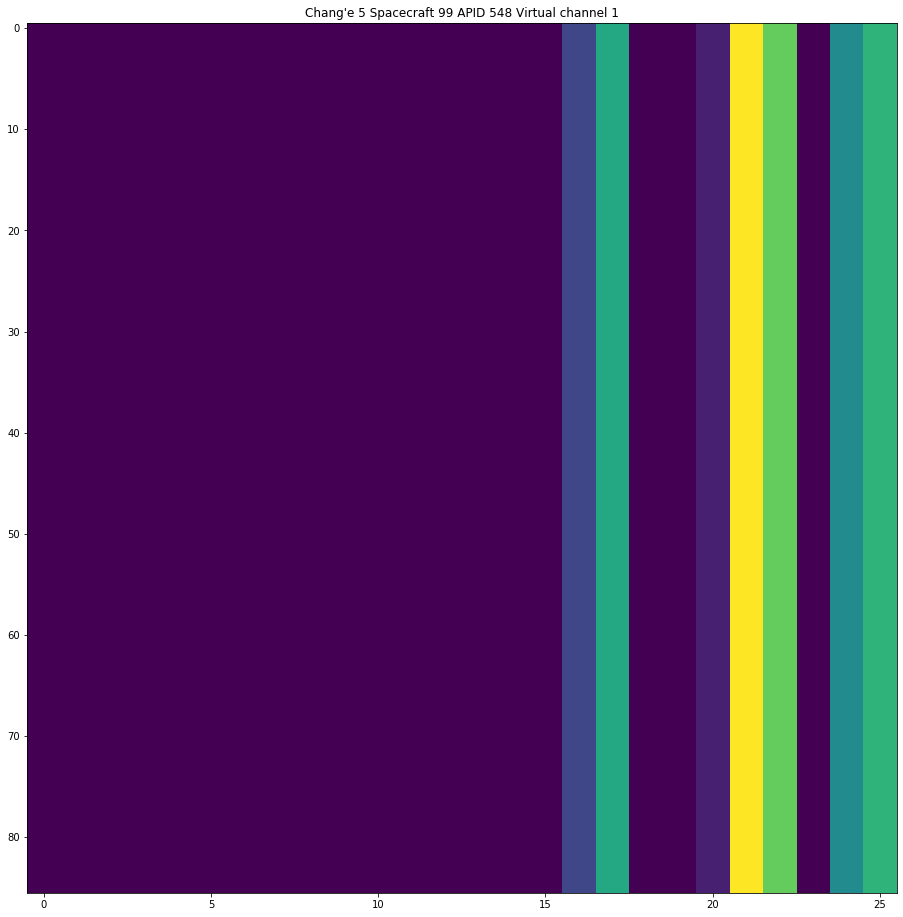

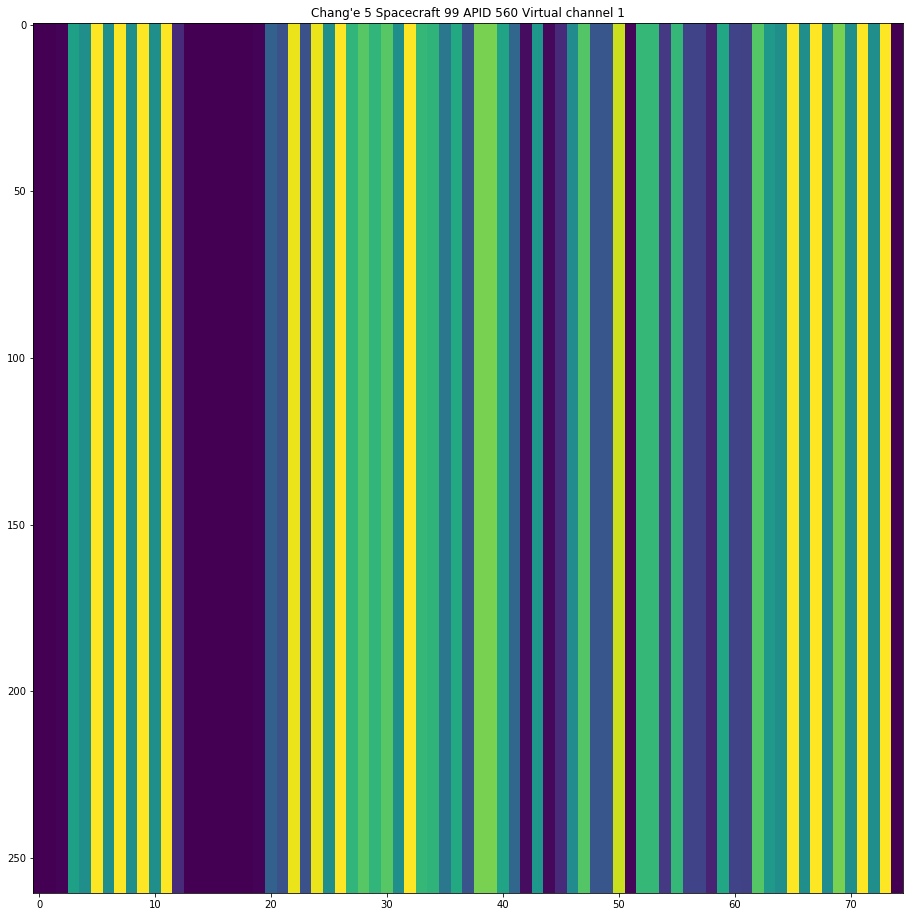

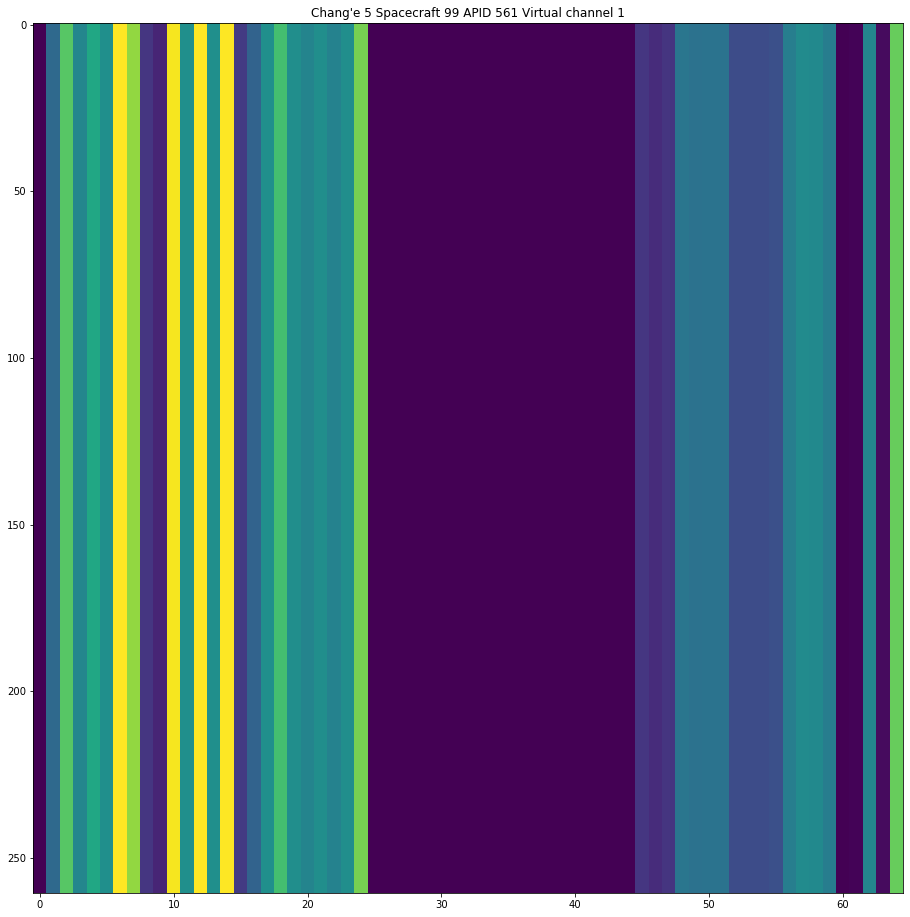

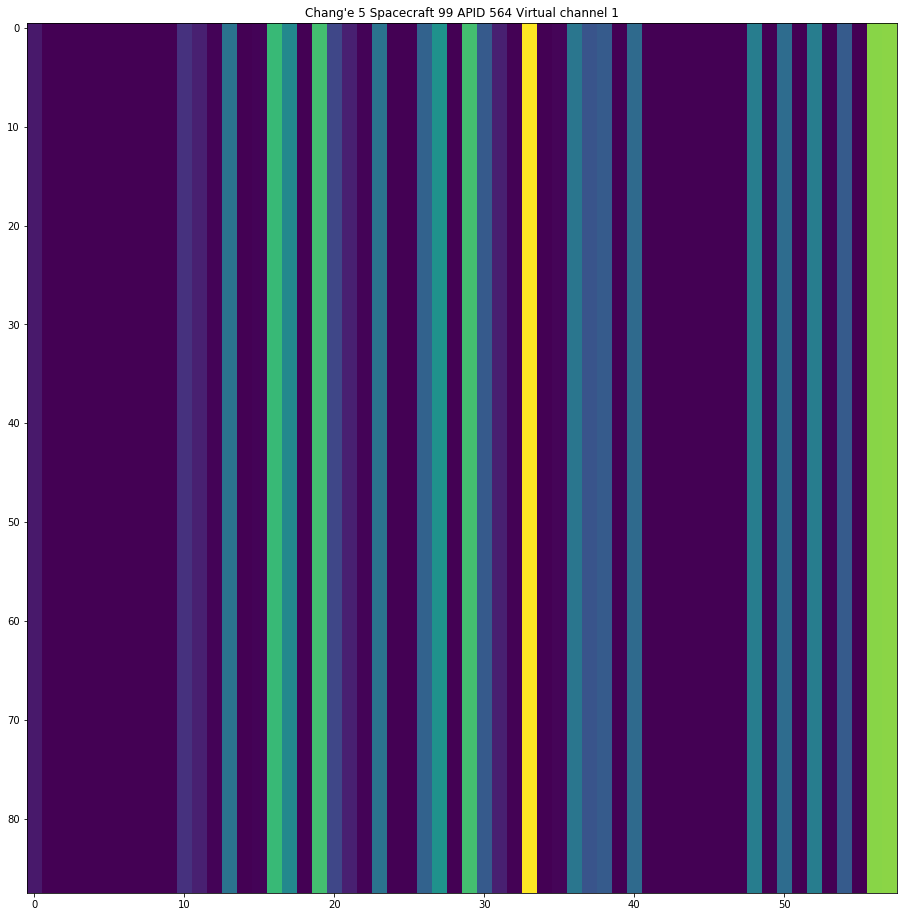

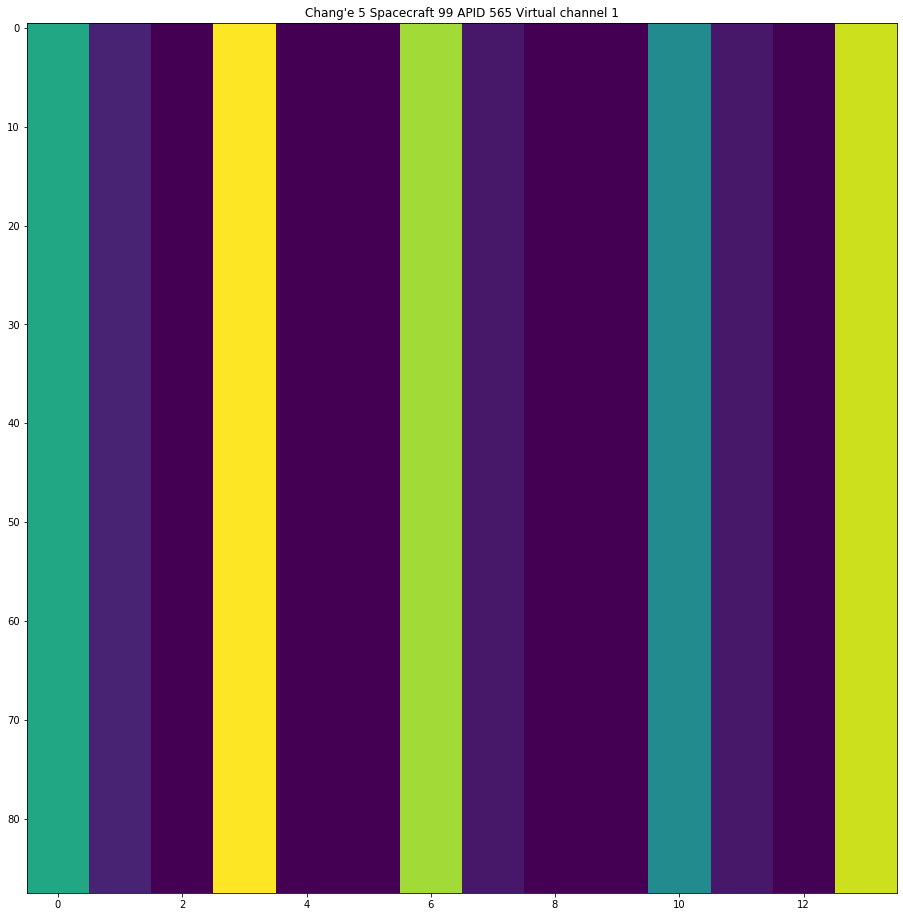

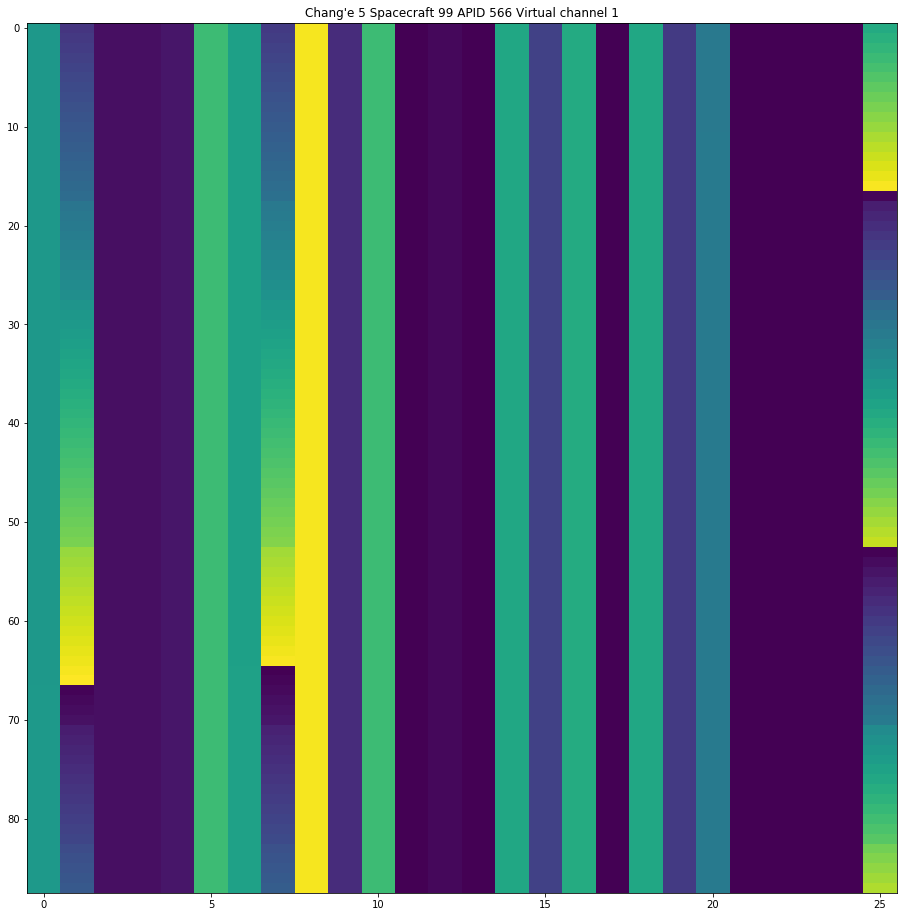

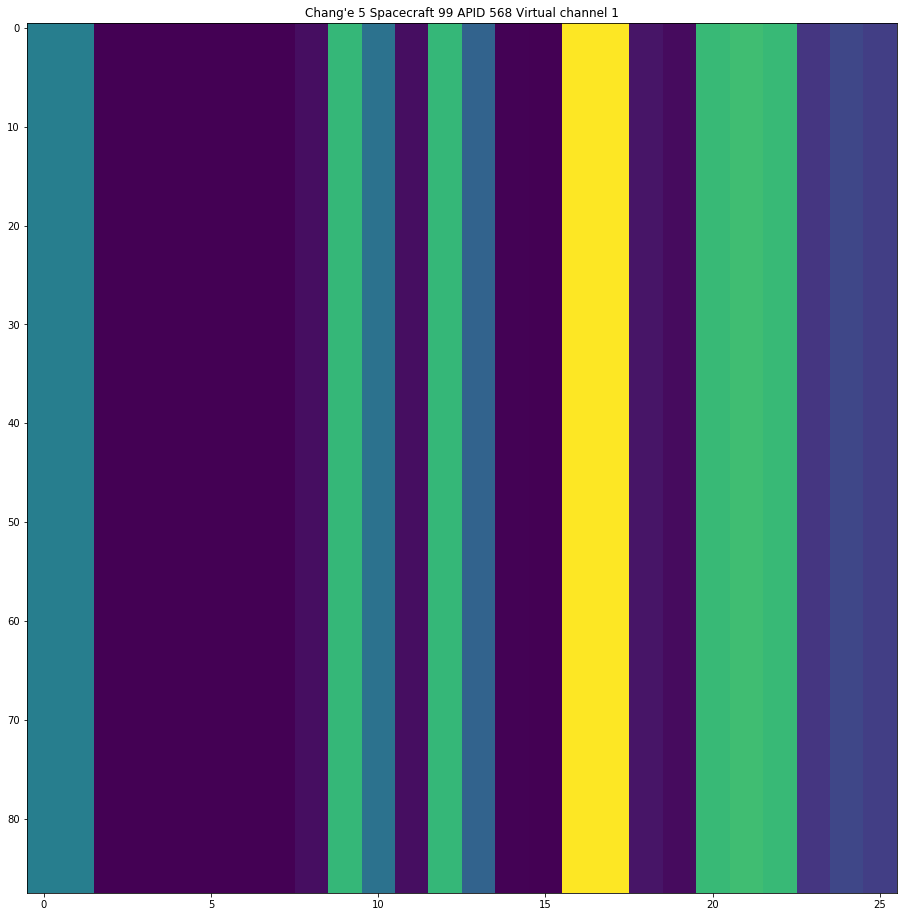

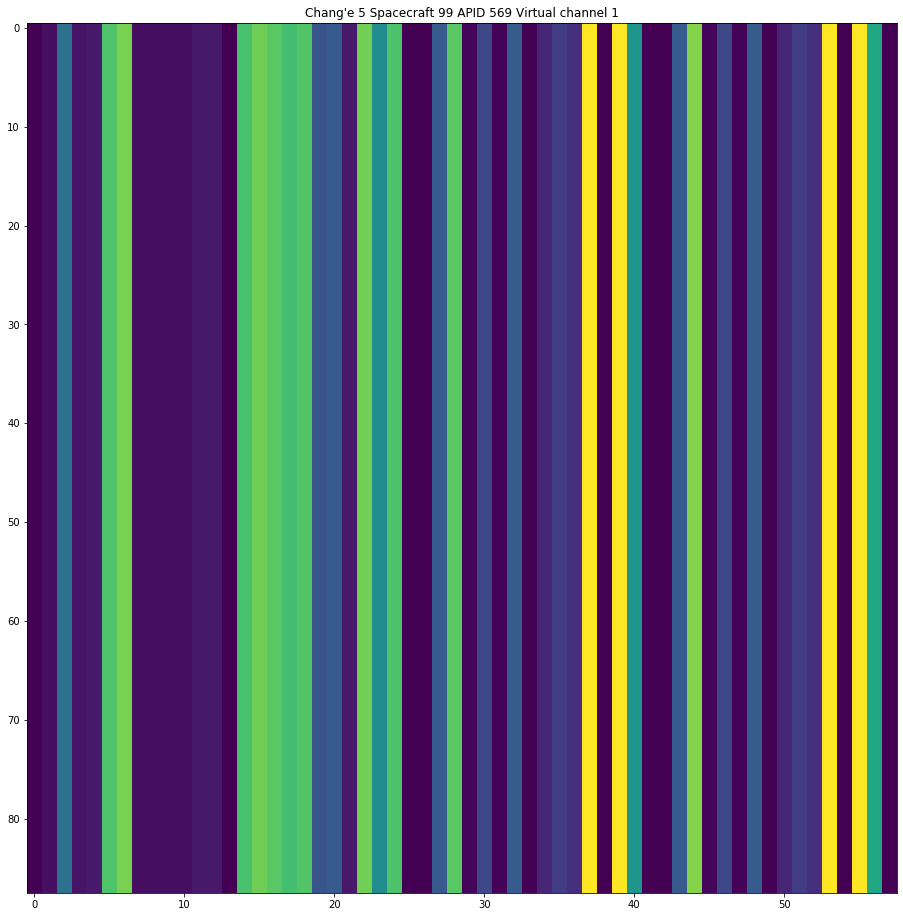

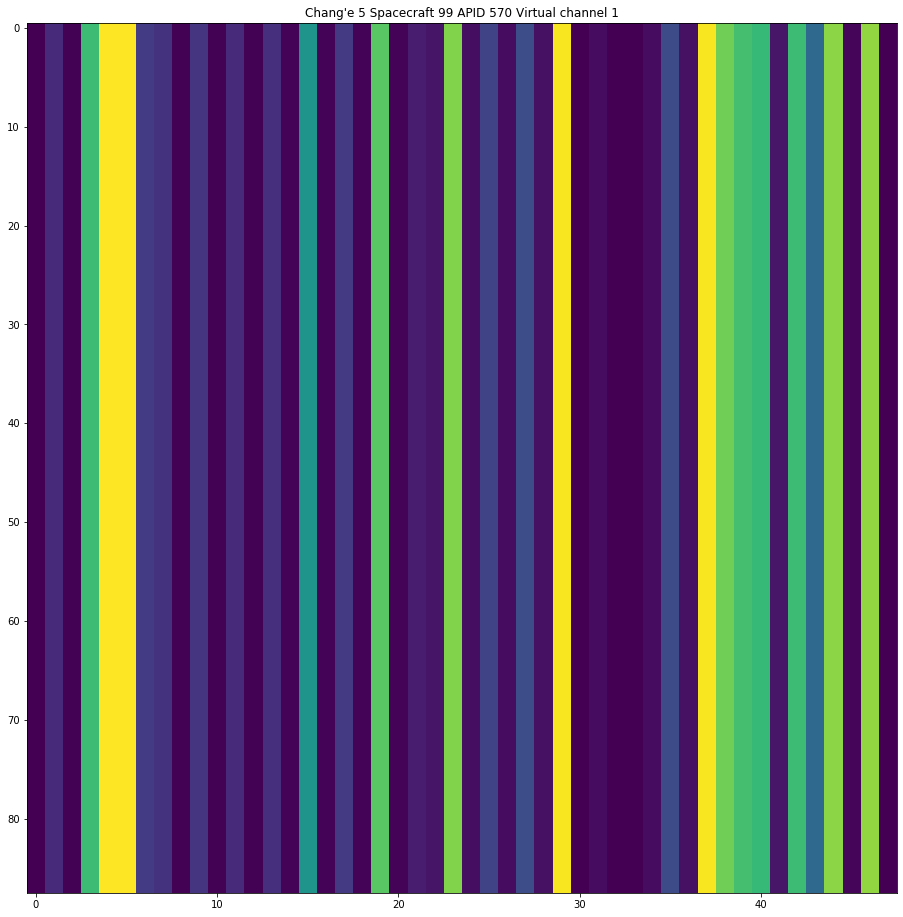

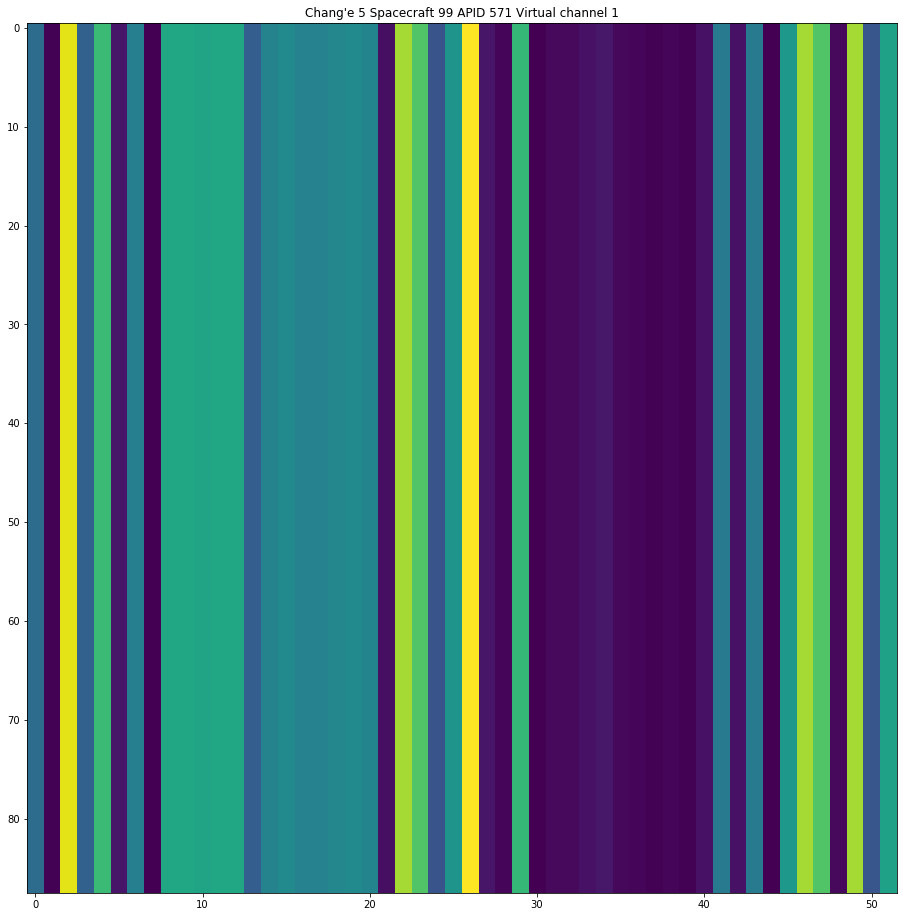

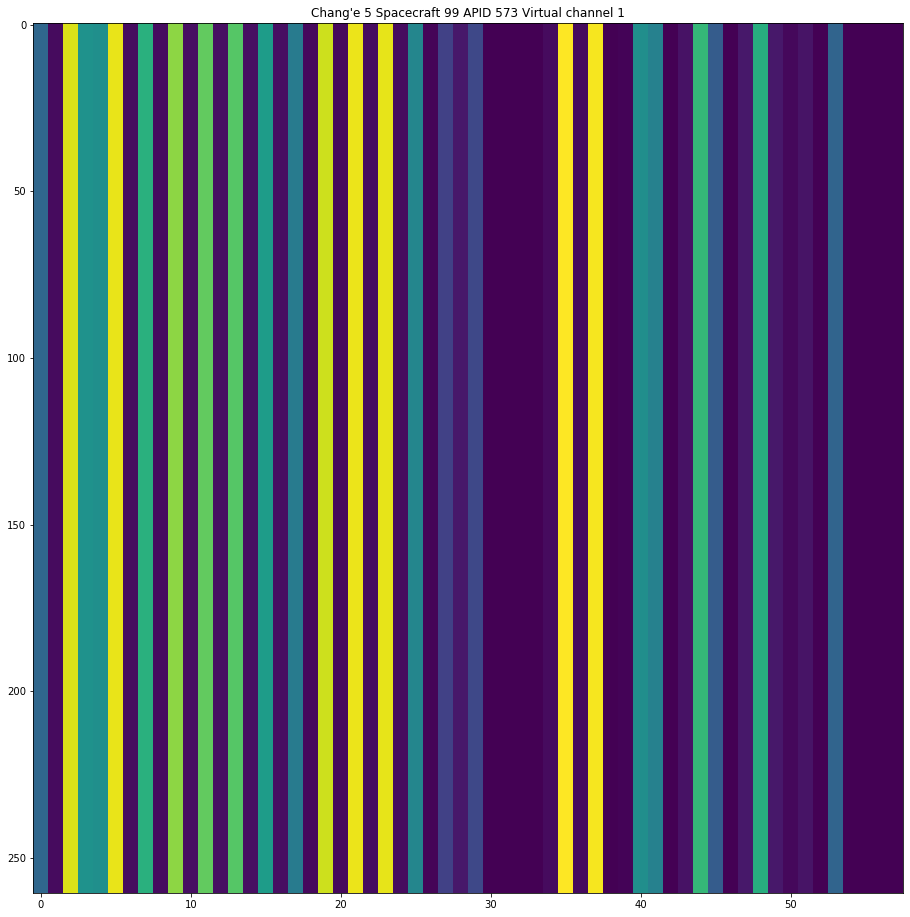

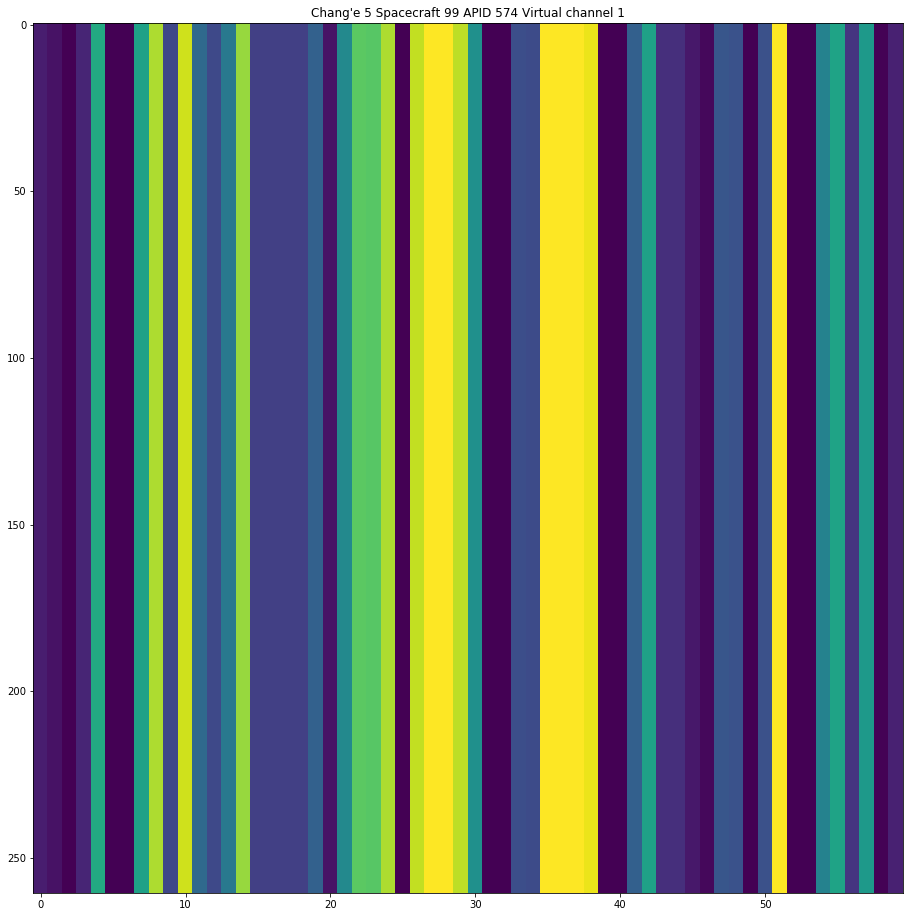

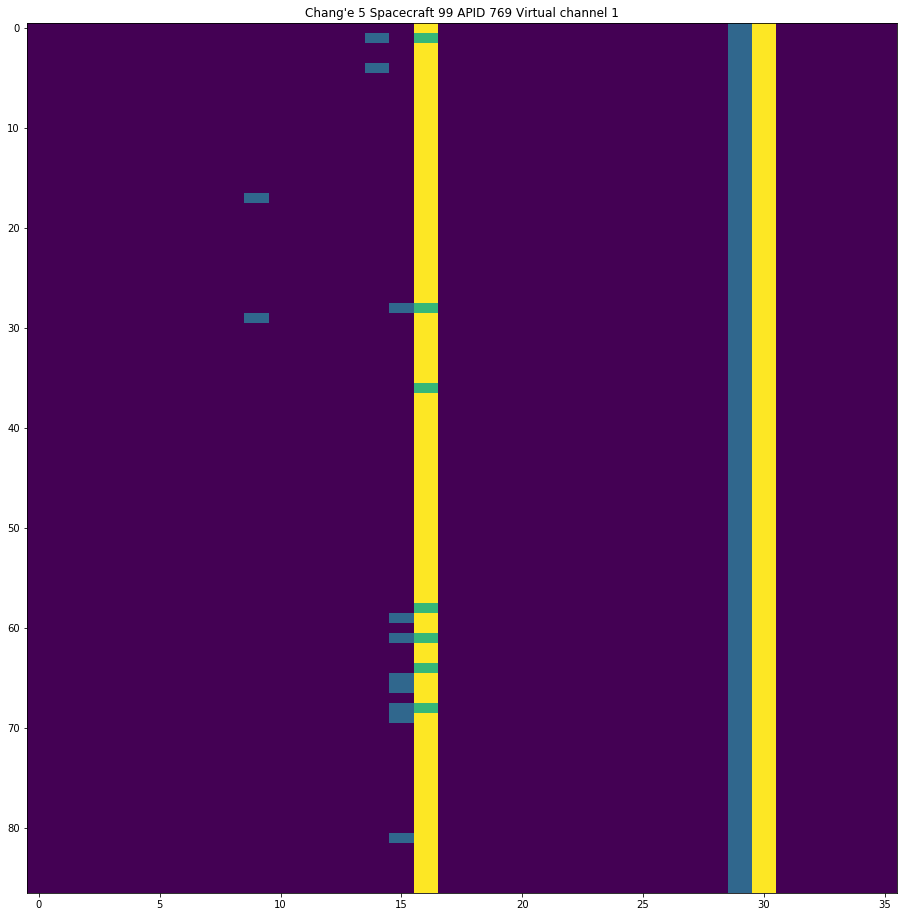

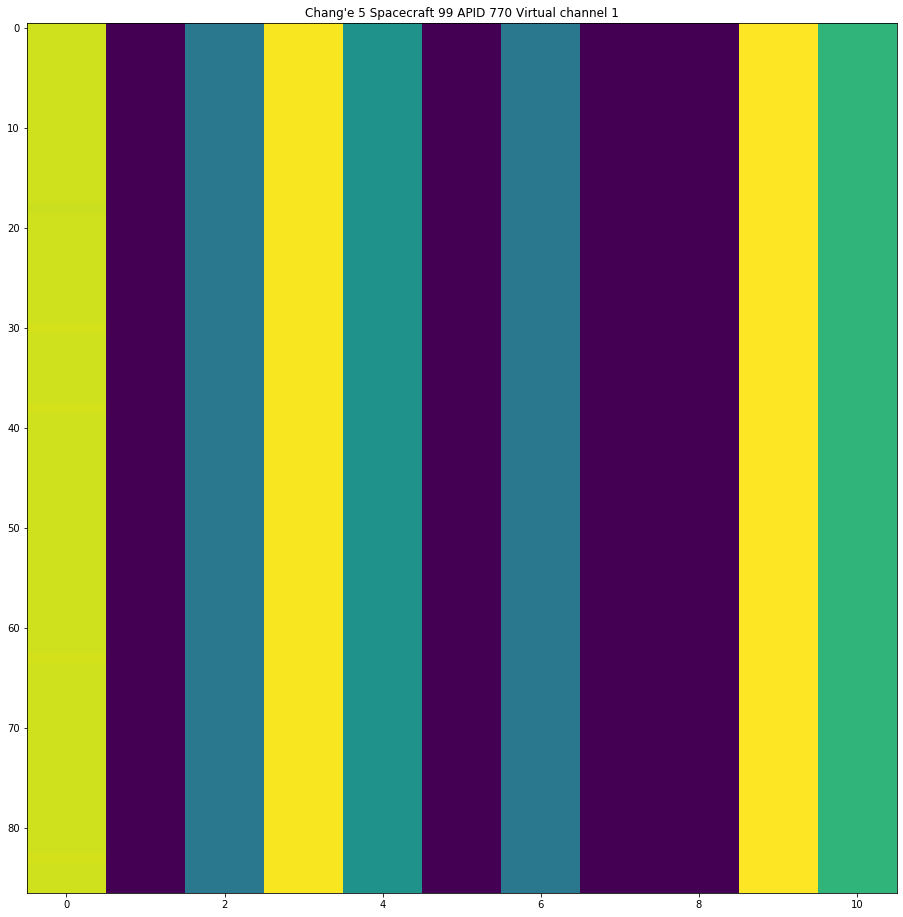

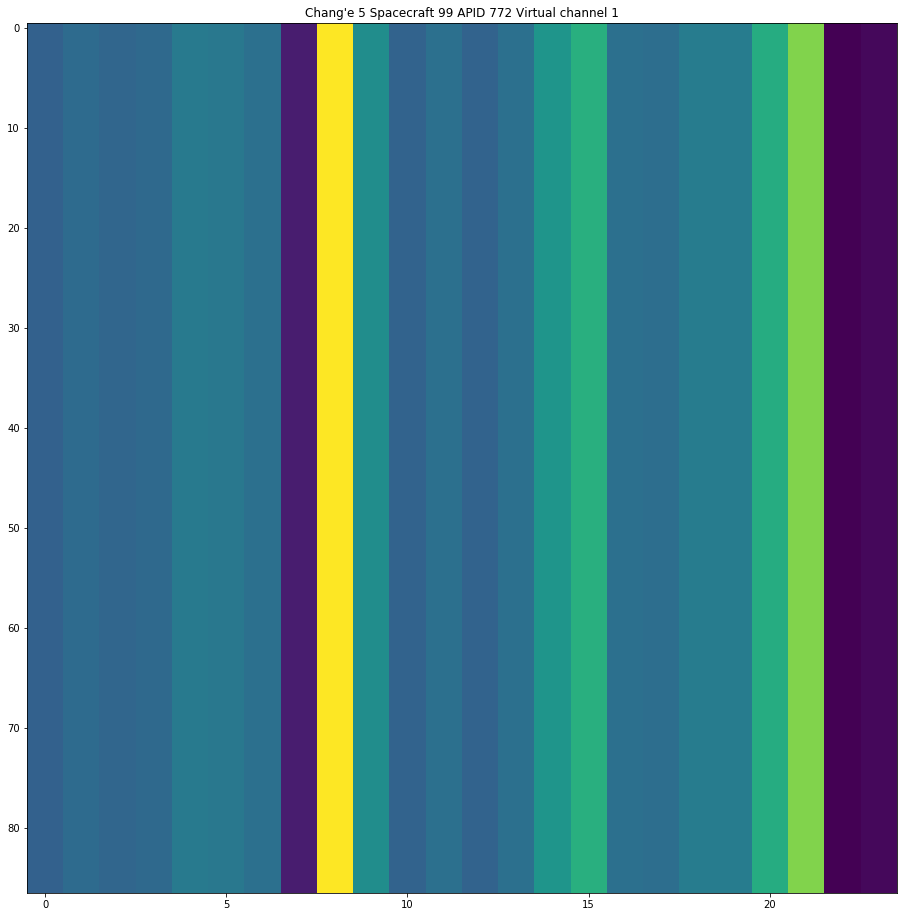

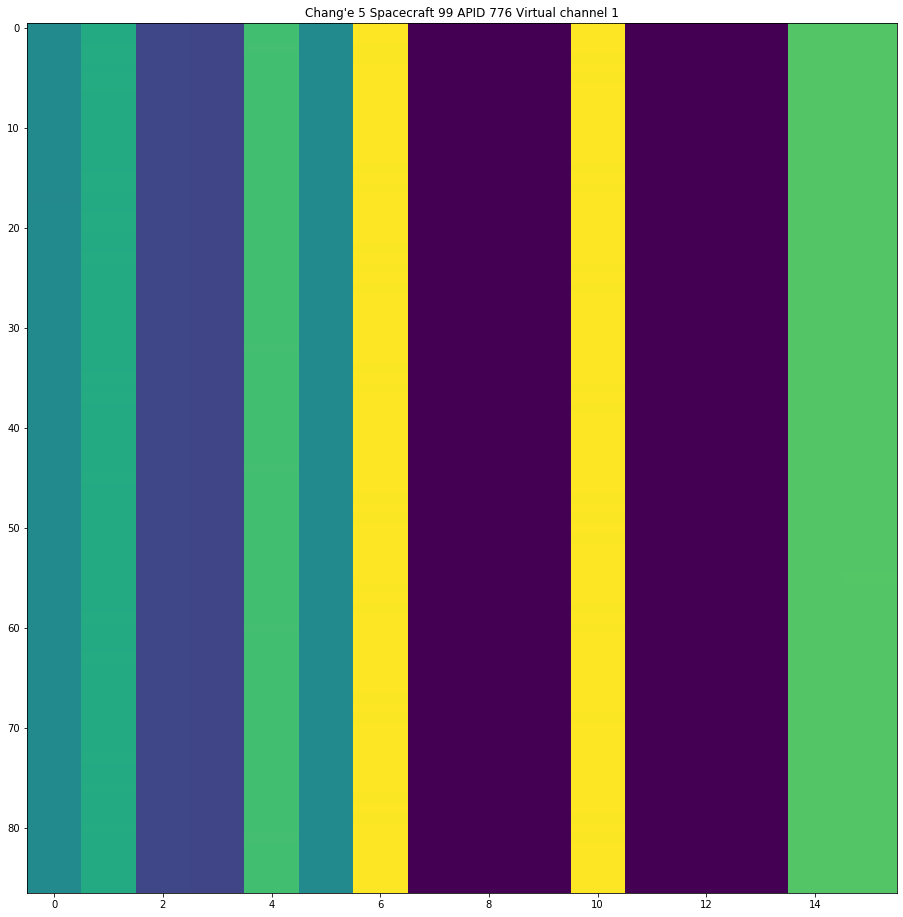

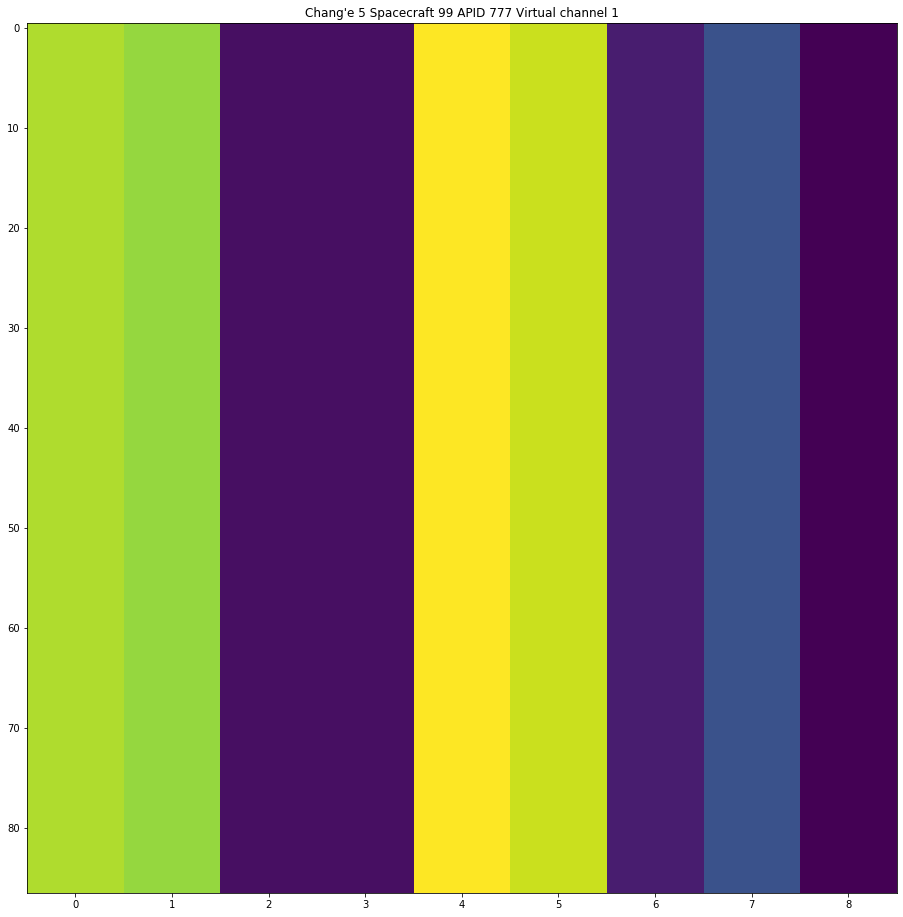

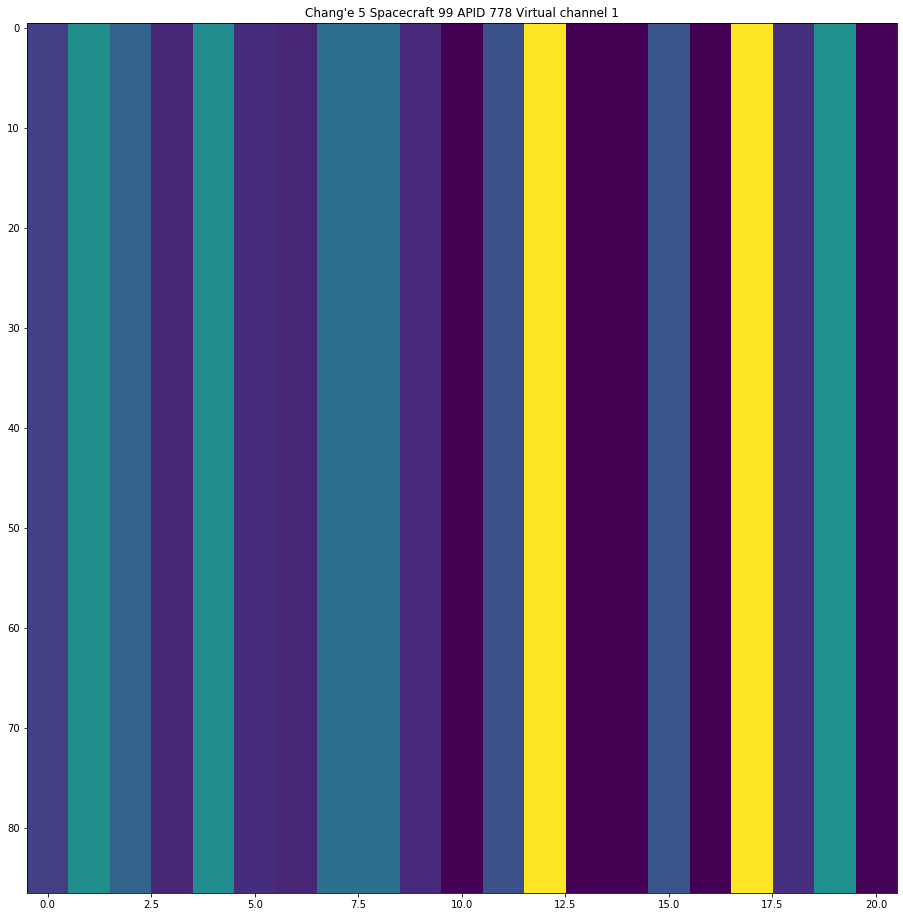

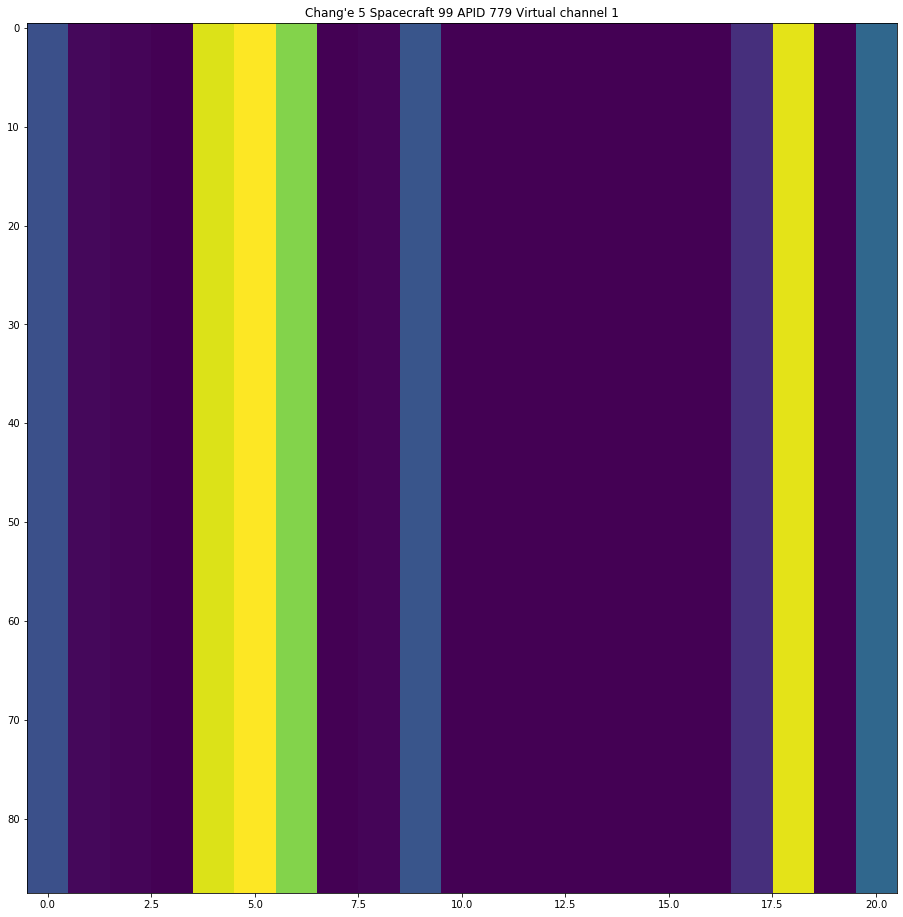

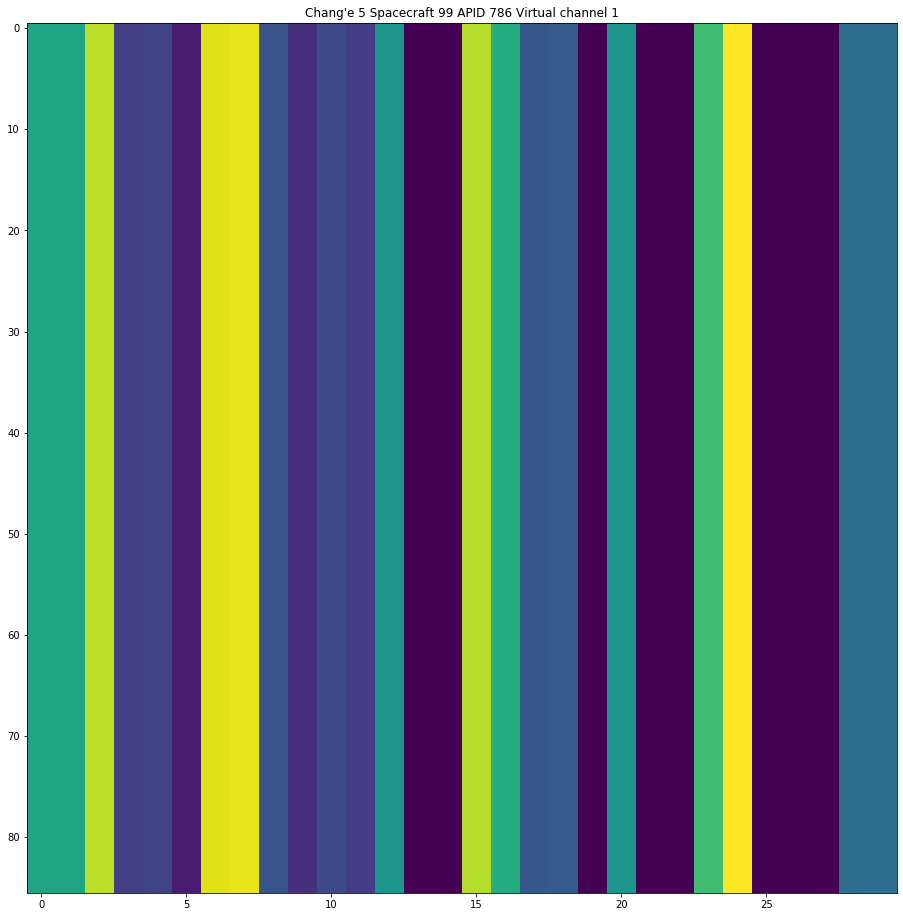

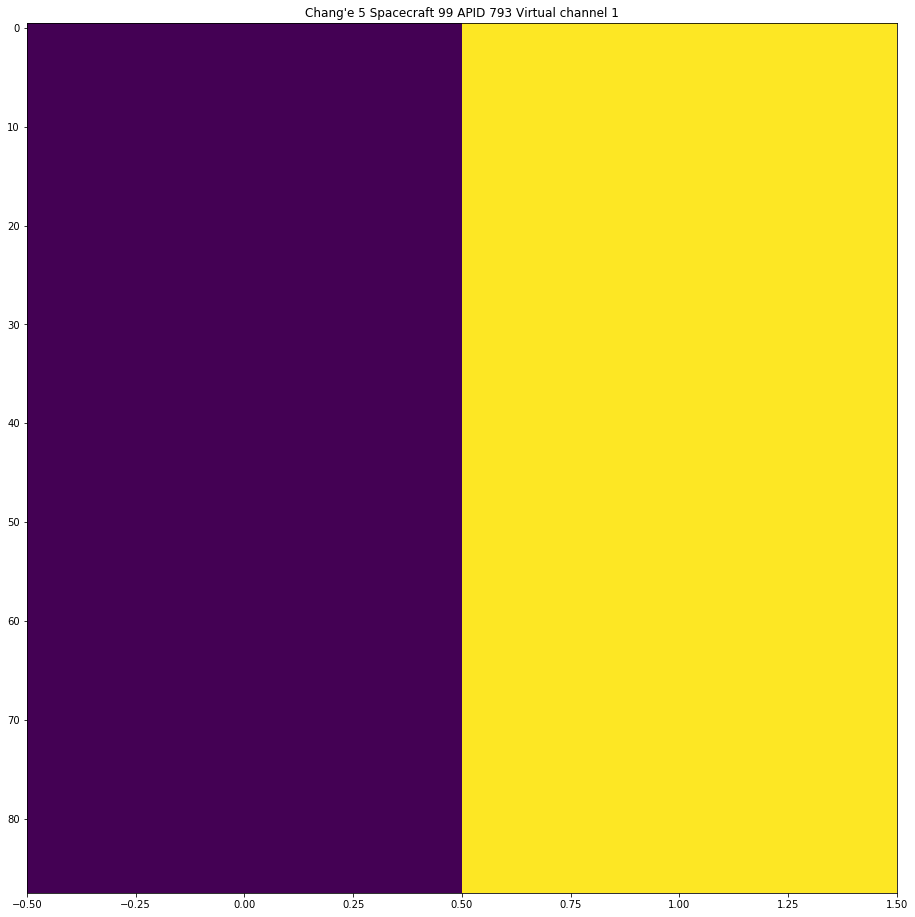

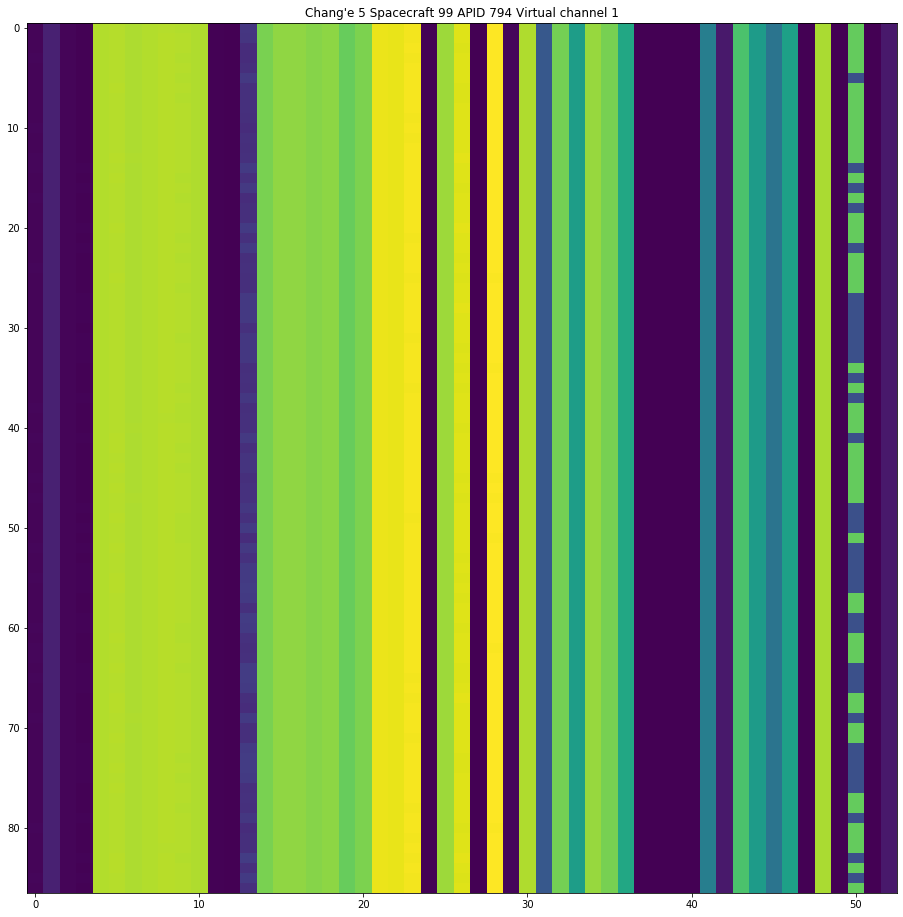

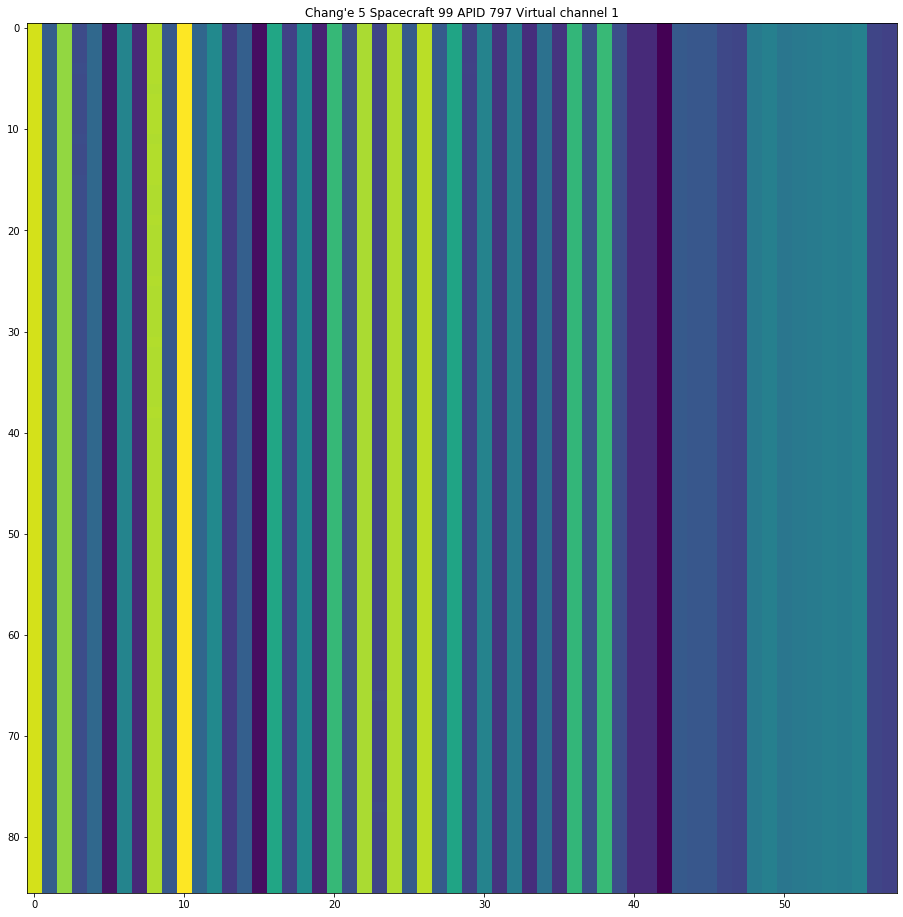

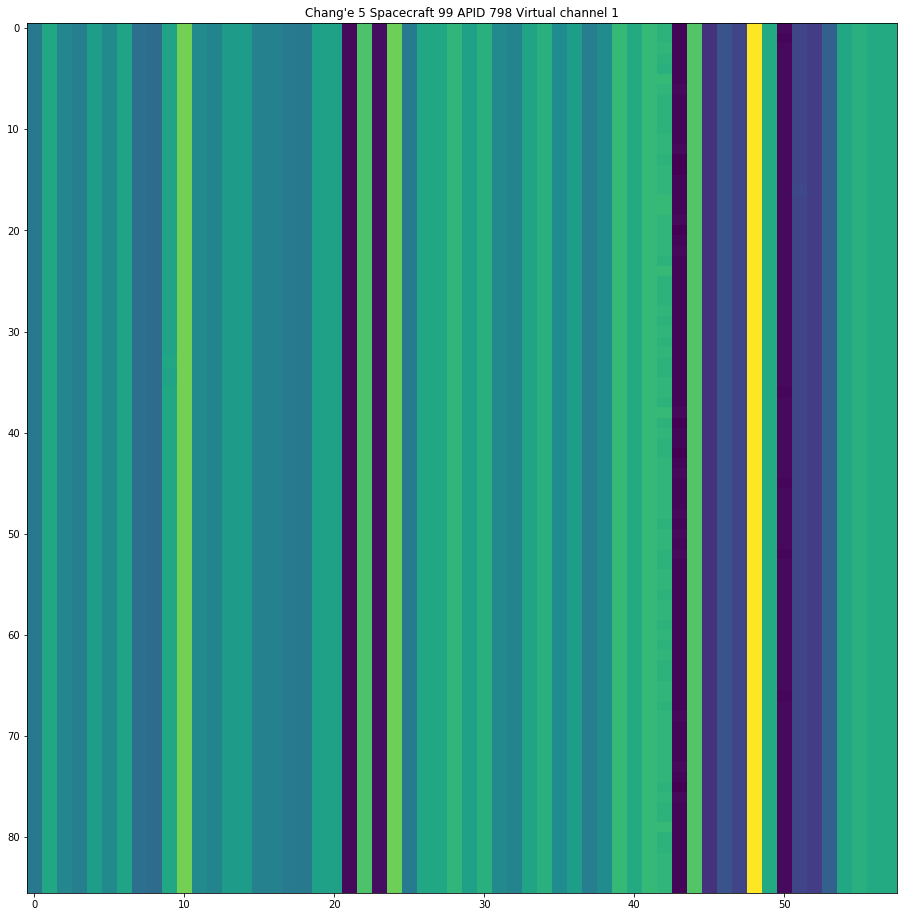

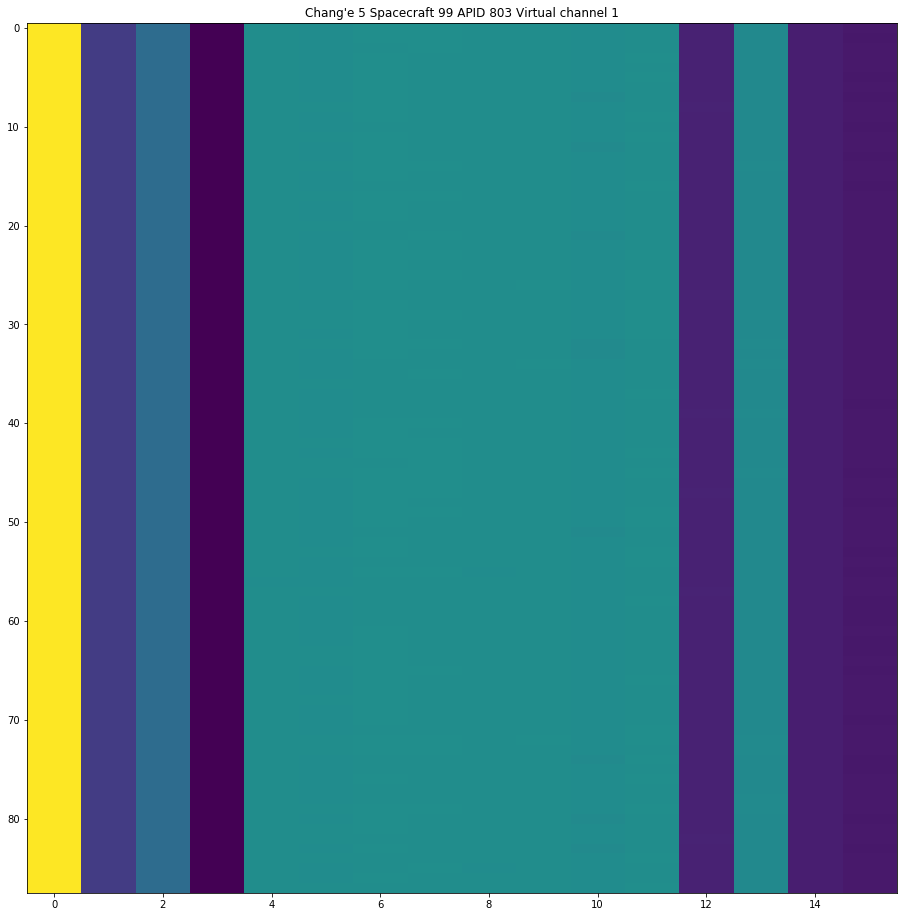

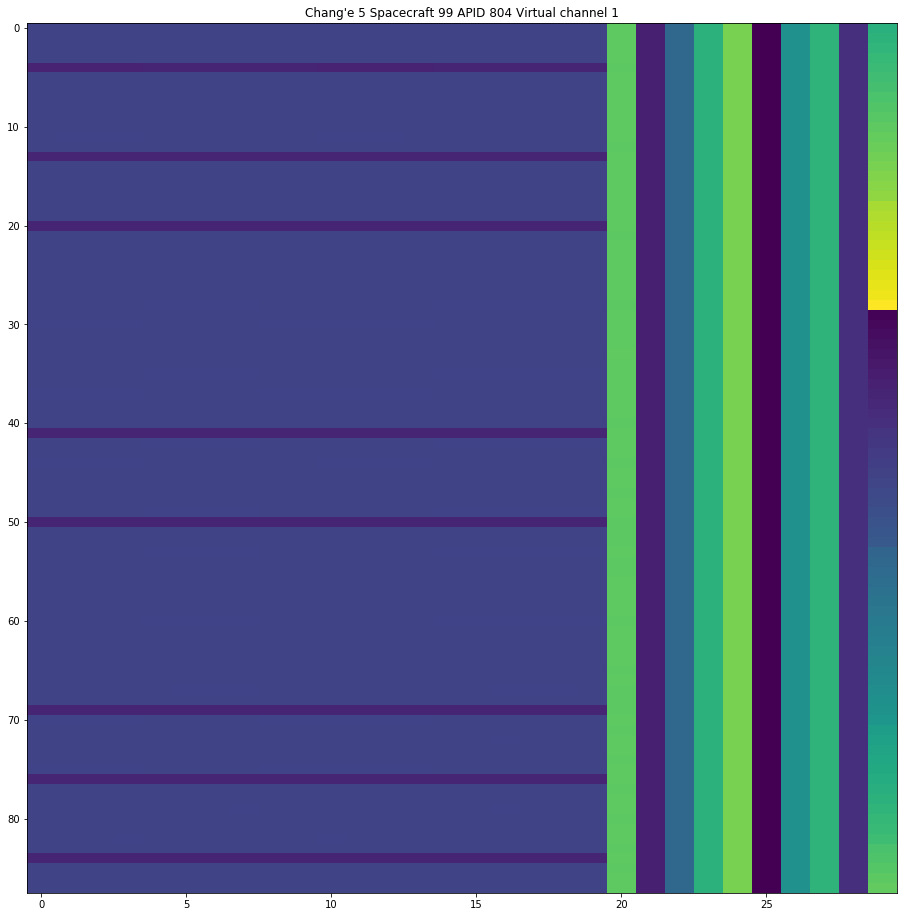

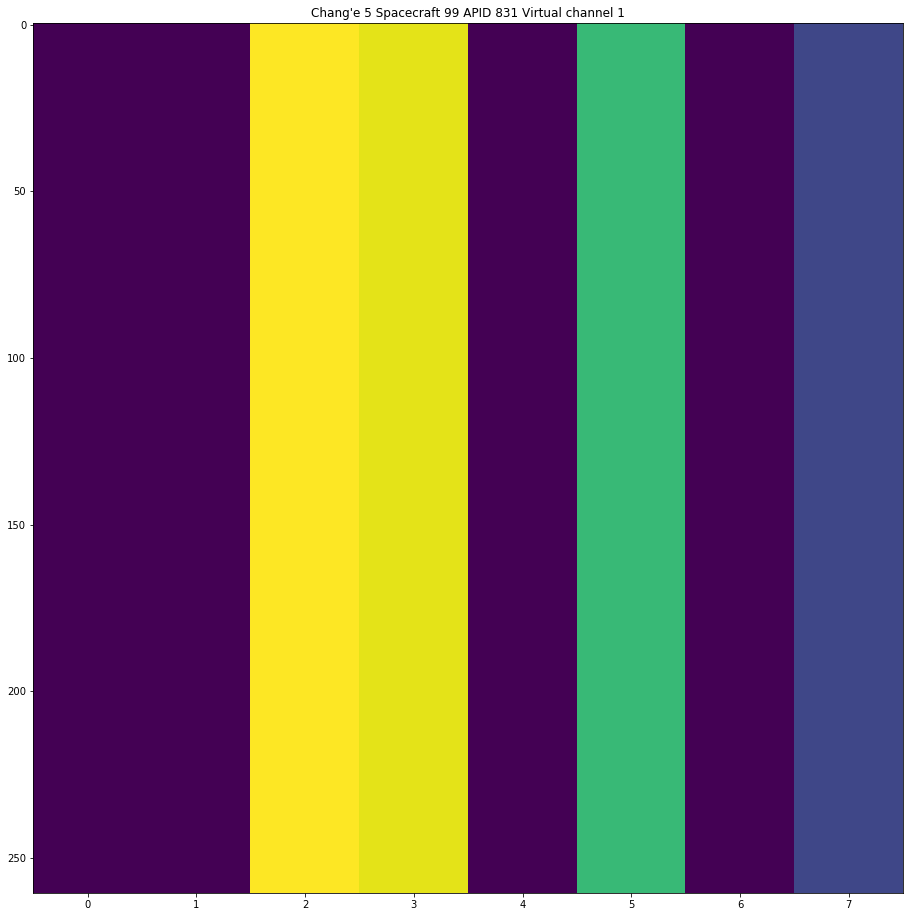

In [41]:
plot_apids(by_apid, 99, 1)

## Virtual channel 40

In [42]:
vc40 = [a for a in aos if a.primary_header.virtual_channel_id == 40]
[a.primary_header for a in vc40]

[Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=40, virtual_channel_frame_count=2722, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=40, virtual_channel_frame_count=2723, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=99, virtual_channel_id=40, virtual_channel_frame_count=2724, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0)]

In [43]:
get_timestamps([a.insert_zone.timestamp for a in vc40])

array(['2020-12-02T21:08:35', '2020-12-02T21:09:35',
       '2020-12-02T21:10:35'], dtype='datetime64[s]')

In [44]:
[a.insert_zone for a in vc40]

[Container(unknown=61680, timestamp=263164115),
 Container(unknown=61680, timestamp=263164175),
 Container(unknown=61680, timestamp=263164235)]

In [45]:
hex(61680)

'0xf0f0'

In [46]:
frames_vc40 = frames[[a.primary_header.virtual_channel_id == 40
                      and a.primary_header.transfer_frame_version_number == 1
                      for a in aos]]

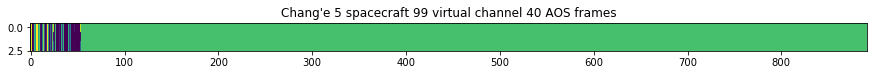

In [47]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames_vc40, aspect = 10)
plt.title("Chang'e 5 spacecraft 99 virtual channel 40 AOS frames");

In [48]:
[ccsds.SpacePacketPrimaryHeader.parse(a) for a in frames_vc40[:,12:]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=630, sequence_flags=3, packet_sequence_count_or_name=1099, data_length=35),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=630, sequence_flags=3, packet_sequence_count_or_name=1100, data_length=35),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=630, sequence_flags=3, packet_sequence_count_or_name=1101, data_length=35)]

In [49]:
frames_vc40[:,12+6:12+6+8]

array([[235, 144,   4,  75,  15, 175, 144, 211],
       [235, 144,   4,  76,  15, 175, 145,  15],
       [235, 144,   4,  77,  15, 175, 145,  75]], dtype=uint8)

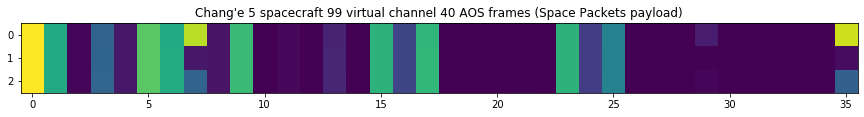

In [50]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames_vc40[:,12+6:12+6+36], aspect = 1)
plt.title("Chang'e 5 spacecraft 99 virtual channel 40 AOS frames (Space Packets payload)");